In [1]:
import numpy as np
from scipy.linalg import solve_continuous_are
import torch
import torch.nn as nn

# System parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.eye(2)  # S = I_2

# Solve the stochastic Riccati equation for P
# AᵀP + PA - PBR⁻¹BᵀP + Q - ρP + PGGᵀP = 0
# We'll solve this iteratively

def solve_stochastic_riccati(A, B, G, Q, R, rho, max_iter=1000, tol=1e-8):
    """Solve the stochastic Riccati equation iteratively"""
    n = A.shape[0]
    P = np.eye(n)  # Initial guess
    
    for i in range(max_iter):
        # Fixed-point iteration
        A_modified = A - (rho/2) * np.eye(n) + 0.5 * G @ G.T @ P
        P_new = solve_continuous_are(A_modified, B, Q, R)
        
        if np.linalg.norm(P_new - P) < tol:
            print(f"Converged after {i+1} iterations")
            break
        
        P = P_new
    
    return P

# Compute analytical solution
P_analytical = solve_stochastic_riccati(A, B, G, Q, R, rho)
K_analytical = np.linalg.inv(R) @ B.T @ P_analytical

print("Analytical Solution:")
print(f"P = \n{P_analytical}")
print(f"K = {K_analytical.flatten()}")

# Stopping region: {x: xᵀPx ≤ xᵀSx} = {x: xᵀ(P-S)x ≤ 0}
P_minus_S = P_analytical - S
print(f"P - S = \n{P_minus_S}")

# Check eigenvalues to understand stopping region shape
eigvals = np.linalg.eigvals(P_minus_S)
print(f"Eigenvalues of (P-S): {eigvals}")

Converged after 5 iterations
Analytical Solution:
P = 
[[1.15725402 0.21316998]
 [0.21316998 0.22563788]]
K = [0.21316998 0.22563788]
P - S = 
[[ 0.15725402  0.21316998]
 [ 0.21316998 -0.77436212]]
Eigenvalues of (P-S): [ 0.20371405 -0.82082215]


In [2]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert to PyTorch tensors
A_tensor = torch.tensor(A, dtype=torch.float32, device=device)
B_tensor = torch.tensor(B, dtype=torch.float32, device=device)
G_tensor = torch.tensor(G, dtype=torch.float32, device=device)
Q_tensor = torch.tensor(Q, dtype=torch.float32, device=device)
R_tensor = torch.tensor(R, dtype=torch.float32, device=device)
S_tensor = torch.tensor(S, dtype=torch.float32, device=device)
R_inv = torch.linalg.inv(R_tensor)
G_GT = G_tensor @ G_tensor.T
B_Rinv_BT = B_tensor @ R_inv @ B_tensor.T

class ValueNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=5):
        super(ValueNetwork, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class BoundaryNetwork(nn.Module):
    """Network to approximate the stopping boundary function b(x)"""
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(BoundaryNetwork, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())  # Output between 0 and 1
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class OptimalStoppingPINN:
    def __init__(self, V_net, b_net, A, B, Q, R_inv, G_GT, S, rho):
        self.V_net = V_net
        self.b_net = b_net
        self.A = A
        self.B = B
        self.Q = Q
        self.R_inv = R_inv
        self.G_GT = G_GT
        self.S = S
        self.rho = rho
        self.B_Rinv_BT = B @ R_inv @ B.T
    
    def compute_gradients(self, x):
        """Compute V, ∇V, and ∇²V"""
        x.requires_grad_(True)
        V = self.V_net(x)
        
        # Compute gradient ∇V
        grad_V = torch.autograd.grad(V, x, 
                                   grad_outputs=torch.ones_like(V),
                                   create_graph=True,
                                   retain_graph=True)[0]
        
        # Compute Hessian diagonal (trace approximation)
        hessian_diag = []
        for i in range(x.shape[1]):
            grad_V_i = grad_V[:, i:i+1]
            hessian_i = torch.autograd.grad(grad_V_i, x,
                                          grad_outputs=torch.ones_like(grad_V_i),
                                          create_graph=True,
                                          retain_graph=True)[0][:, i:i+1]
            hessian_diag.append(hessian_i)
        
        trace_hessian = torch.cat(hessian_diag, dim=1).sum(dim=1, keepdim=True)
        
        return V, grad_V, trace_hessian
    
    def physics_loss(self, x):
        """HJB variational inequality loss"""
        V, grad_V, trace_hessian = self.compute_gradients(x)
        b = self.b_net(x)  # Boundary indicator: ~1 in stopping region, ~0 in continuation
        
        # Compute S(x) = xᵀSx
        S_x = torch.einsum('bi,ij,bj->b', x, self.S, x).unsqueeze(1)
        
        # HJB term in continuation region
        term1 = 0.5 * torch.einsum('bi,ij,bj->b', x, self.Q, x).unsqueeze(1)
        term2 = torch.einsum('bi,ij,bj->b', grad_V, self.A, x).unsqueeze(1)
        term3 = 0.5 * trace_hessian * torch.trace(self.G_GT).unsqueeze(0)
        
        # Nonlinear term with stochastic part
        quad_form_control = torch.einsum('bi,ij,bj->b', grad_V, self.B_Rinv_BT, grad_V).unsqueeze(1)
        stochastic_term = 0.5 * torch.einsum('bi,ij,bj->b', grad_V, self.G_GT, grad_V).unsqueeze(1)
        
        HJB_operator = self.rho * V - (term1 + term2 + term3 - 0.5 * quad_form_control + stochastic_term)
        
        # Variational inequality: min{HJB_operator, V - S_x} = 0
        # This means both terms should be ≥ 0 and at least one = 0
        
        continuation_loss = torch.relu(HJB_operator)  # Should be ≥ 0
        stopping_loss = torch.relu(V - S_x)  # Should be ≥ 0
        complementarity_loss = (HJB_operator * (V - S_x))**2  # Should be ≈ 0
        
        # Use boundary network to weight the losses
        continuation_weight = 1 - b  # More weight in continuation region
        stopping_weight = b  # More weight in stopping region
        
        total_loss = (continuation_weight * continuation_loss + 
                     stopping_weight * stopping_loss + 
                     complementarity_loss)
        
        return torch.mean(total_loss)
    
    def boundary_consistency_loss(self, x):
        """Ensure boundary network is consistent with value function"""
        V = self.V_net(x)
        S_x = torch.einsum('bi,ij,bj->b', x, self.S, x).unsqueeze(1)
        b = self.b_net(x)
        
        # In stopping region (b ≈ 1), V should be close to S_x
        stopping_loss = b * (V - S_x)**2
        
        # In continuation region (b ≈ 0), V should be ≤ S_x
        continuation_loss = (1 - b) * torch.relu(V - S_x)**2
        
        return torch.mean(stopping_loss + continuation_loss)

In [5]:
def train_optimal_stopping_pinn(pinn, epochs=5000, print_every=500):
    """Train the optimal stopping PINN"""
    
    # Generate training data
    def generate_training_data(num_points=500):
        # Sample more points near expected boundary
        radial = torch.rand(num_points) * 3  # Up to radius 3
        angle = torch.rand(num_points) * 2 * torch.pi
        x1 = radial * torch.cos(angle)
        x2 = radial * torch.sin(angle)
        return torch.stack([x1, x2], dim=1).to(device)
    
    optimizer_V = torch.optim.Adam(pinn.V_net.parameters(), lr=1e-3)
    optimizer_b = torch.optim.Adam(pinn.b_net.parameters(), lr=1e-3)
    
    losses = []
    
    for epoch in range(epochs):
        x_domain = generate_training_data()
        
        # Train value network
        optimizer_V.zero_grad()
        loss_physics = pinn.physics_loss(x_domain)
        loss_physics.backward()
        optimizer_V.step()
        
        # Train boundary network
        optimizer_b.zero_grad()
        loss_boundary = pinn.boundary_consistency_loss(x_domain)
        loss_boundary.backward()
        optimizer_b.step()
        
        total_loss = loss_physics + loss_boundary
        losses.append(total_loss.item())
        
        if epoch % print_every == 0:
            current_lr_V = optimizer_V.param_groups[0]['lr']
            current_lr_b = optimizer_b.param_groups[0]['lr']
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, '
                  f'Physics: {loss_physics.item():.6f}, Boundary: {loss_boundary.item():.6f}, '
                  f'LR_V: {current_lr_V:.2e}, LR_b: {current_lr_b:.2e}')
    
    return losses

# Initialize and train
V_net = ValueNetwork().to(device)
b_net = BoundaryNetwork().to(device)
pinn = OptimalStoppingPINN(V_net, b_net, A_tensor, B_tensor, Q_tensor, 
                          R_inv, G_GT, S_tensor, rho)

print("Training Optimal Stopping PINN...")
losses = train_optimal_stopping_pinn(pinn)

Training Optimal Stopping PINN...
Epoch 0, Total Loss: 191.060699, Physics: 183.615280, Boundary: 7.445415, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 500, Total Loss: 0.409287, Physics: 0.091461, Boundary: 0.317826, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 1000, Total Loss: 0.513680, Physics: 0.182470, Boundary: 0.331211, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 1500, Total Loss: 0.962129, Physics: 0.125723, Boundary: 0.836406, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 2000, Total Loss: 0.153015, Physics: 0.068601, Boundary: 0.084414, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 2500, Total Loss: 0.222615, Physics: 0.029947, Boundary: 0.192668, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 3000, Total Loss: 0.532166, Physics: 0.088578, Boundary: 0.443588, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 3500, Total Loss: 0.049846, Physics: 0.013944, Boundary: 0.035902, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 4000, Total Loss: 0.156489, Physics: 0.040943, Boundary: 0.115546, LR_V: 1.00e-03, LR_b: 1.00e-03
Epoch 4500, Total Loss: 0.0436

In [6]:
def compare_optimal_stopping_solutions(V_net, b_net, P_analytical, S, x_range=(-3, 3), grid_points=100):
    """Compare PINN with analytical solution"""
    
    # Create test grid
    x1 = np.linspace(x_range[0], x_range[1], grid_points)
    x2 = np.linspace(x_range[0], x_range[1], grid_points)
    X1, X2 = np.meshgrid(x1, x2, indexing='ij')
    x_test_np = np.stack([X1.ravel(), X2.ravel()], axis=1)
    x_test_torch = torch.tensor(x_test_np, dtype=torch.float32, device=device)
    
    # Analytical solutions
    V_analytical = np.array([x.T @ P_analytical @ x if x.T @ (P_analytical - S) @ x > 0 
                           else x.T @ S @ x for x in x_test_np])
    
    region_analytical = np.array([1 if x.T @ (P_analytical - S) @ x > 0 else 0 
                                for x in x_test_np])  # 1 = continue, 0 = stop
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_torch).cpu().numpy().flatten()
        b_pinn = b_net(x_test_torch).cpu().numpy().flatten()
        region_pinn = (b_pinn < 0.5).astype(int)  # b ~ 0: continue, b ~ 1: stop
    
    # Reshape for plotting
    V_analytical_grid = V_analytical.reshape(grid_points, grid_points)
    V_pinn_grid = V_pinn.reshape(grid_points, grid_points)
    region_analytical_grid = region_analytical.reshape(grid_points, grid_points)
    region_pinn_grid = region_pinn.reshape(grid_points, grid_points)
    
    # Compute errors
    V_error = np.abs(V_pinn - V_analytical)
    region_accuracy = np.mean(region_pinn == region_analytical)
    
    print(f"Region classification accuracy: {region_accuracy:.4f}")
    print(f"V(x) MAE: {np.mean(V_error):.6f}")
    print(f"V(x) Max Error: {np.max(V_error):.6f}")
    
    return {
        'X1': X1, 'X2': X2,
        'V_analytical': V_analytical_grid, 'V_pinn': V_pinn_grid,
        'region_analytical': region_analytical_grid, 'region_pinn': region_pinn_grid,
        'V_error': V_error.reshape(grid_points, grid_points)
    }

In [7]:
def analyze_special_cases():
    """Explain why we stop immediately or never stop for special S matrices"""
    
    S_stop = np.array([[2.1482, 0.2102], [0.2102, 1.2246]])
    S_never = np.array([[0.1482, 0.2102], [0.2102, -0.7754]])
    
    print("=== Analysis of Special Cases ===")
    
    # For S_stop: Check if P - S is negative definite
    P_minus_S_stop = P_analytical - S_stop
    eigvals_stop = np.linalg.eigvals(P_minus_S_stop)
    print(f"S_stop case - Eigenvalues of (P-S): {eigvals_stop}")
    print("Interpretation: Both eigenvalues are NEGATIVE → P-S is negative definite")
    print("→ xᵀ(P-S)x ≤ 0 for ALL x → Entire space is stopping region")
    print("→ Optimal to stop immediately everywhere")
    
    print("\n" + "="*50 + "\n")
    
    # For S_never: Check if P - S is positive definite  
    P_minus_S_never = P_analytical - S_never
    eigvals_never = np.linalg.eigvals(P_minus_S_never)
    print(f"S_never case - Eigenvalues of (P-S): {eigvals_never}")
    print("Interpretation: Both eigenvalues are POSITIVE → P-S is positive definite")
    print("→ xᵀ(P-S)x ≥ 0 for ALL x → Entire space is continuation region") 
    print("→ Never optimal to stop")

=== COMPUTING ANALYTICAL SOLUTION FOR PROBLEM 2 ===
Converged after 5 iterations
Analytical Solution:
P = 
[[1.15725402 0.21316998]
 [0.21316998 0.22563788]]
K = [0.21316998 0.22563788]

Stopping Region Analysis:
P - S = 
[[ 0.15725402  0.21316998]
 [ 0.21316998 -0.77436212]]
Eigenvalues of (P-S): [ 0.20371405 -0.82082215]
Stopping region: x such that xᵀ(P-S)x ≤ 0

=== COMPARING PINN WITH ANALYTICAL SOLUTION ===
Region classification accuracy: 0.2636
V(x) MAE: 3.950596
V(x) Max Error: 13.620779


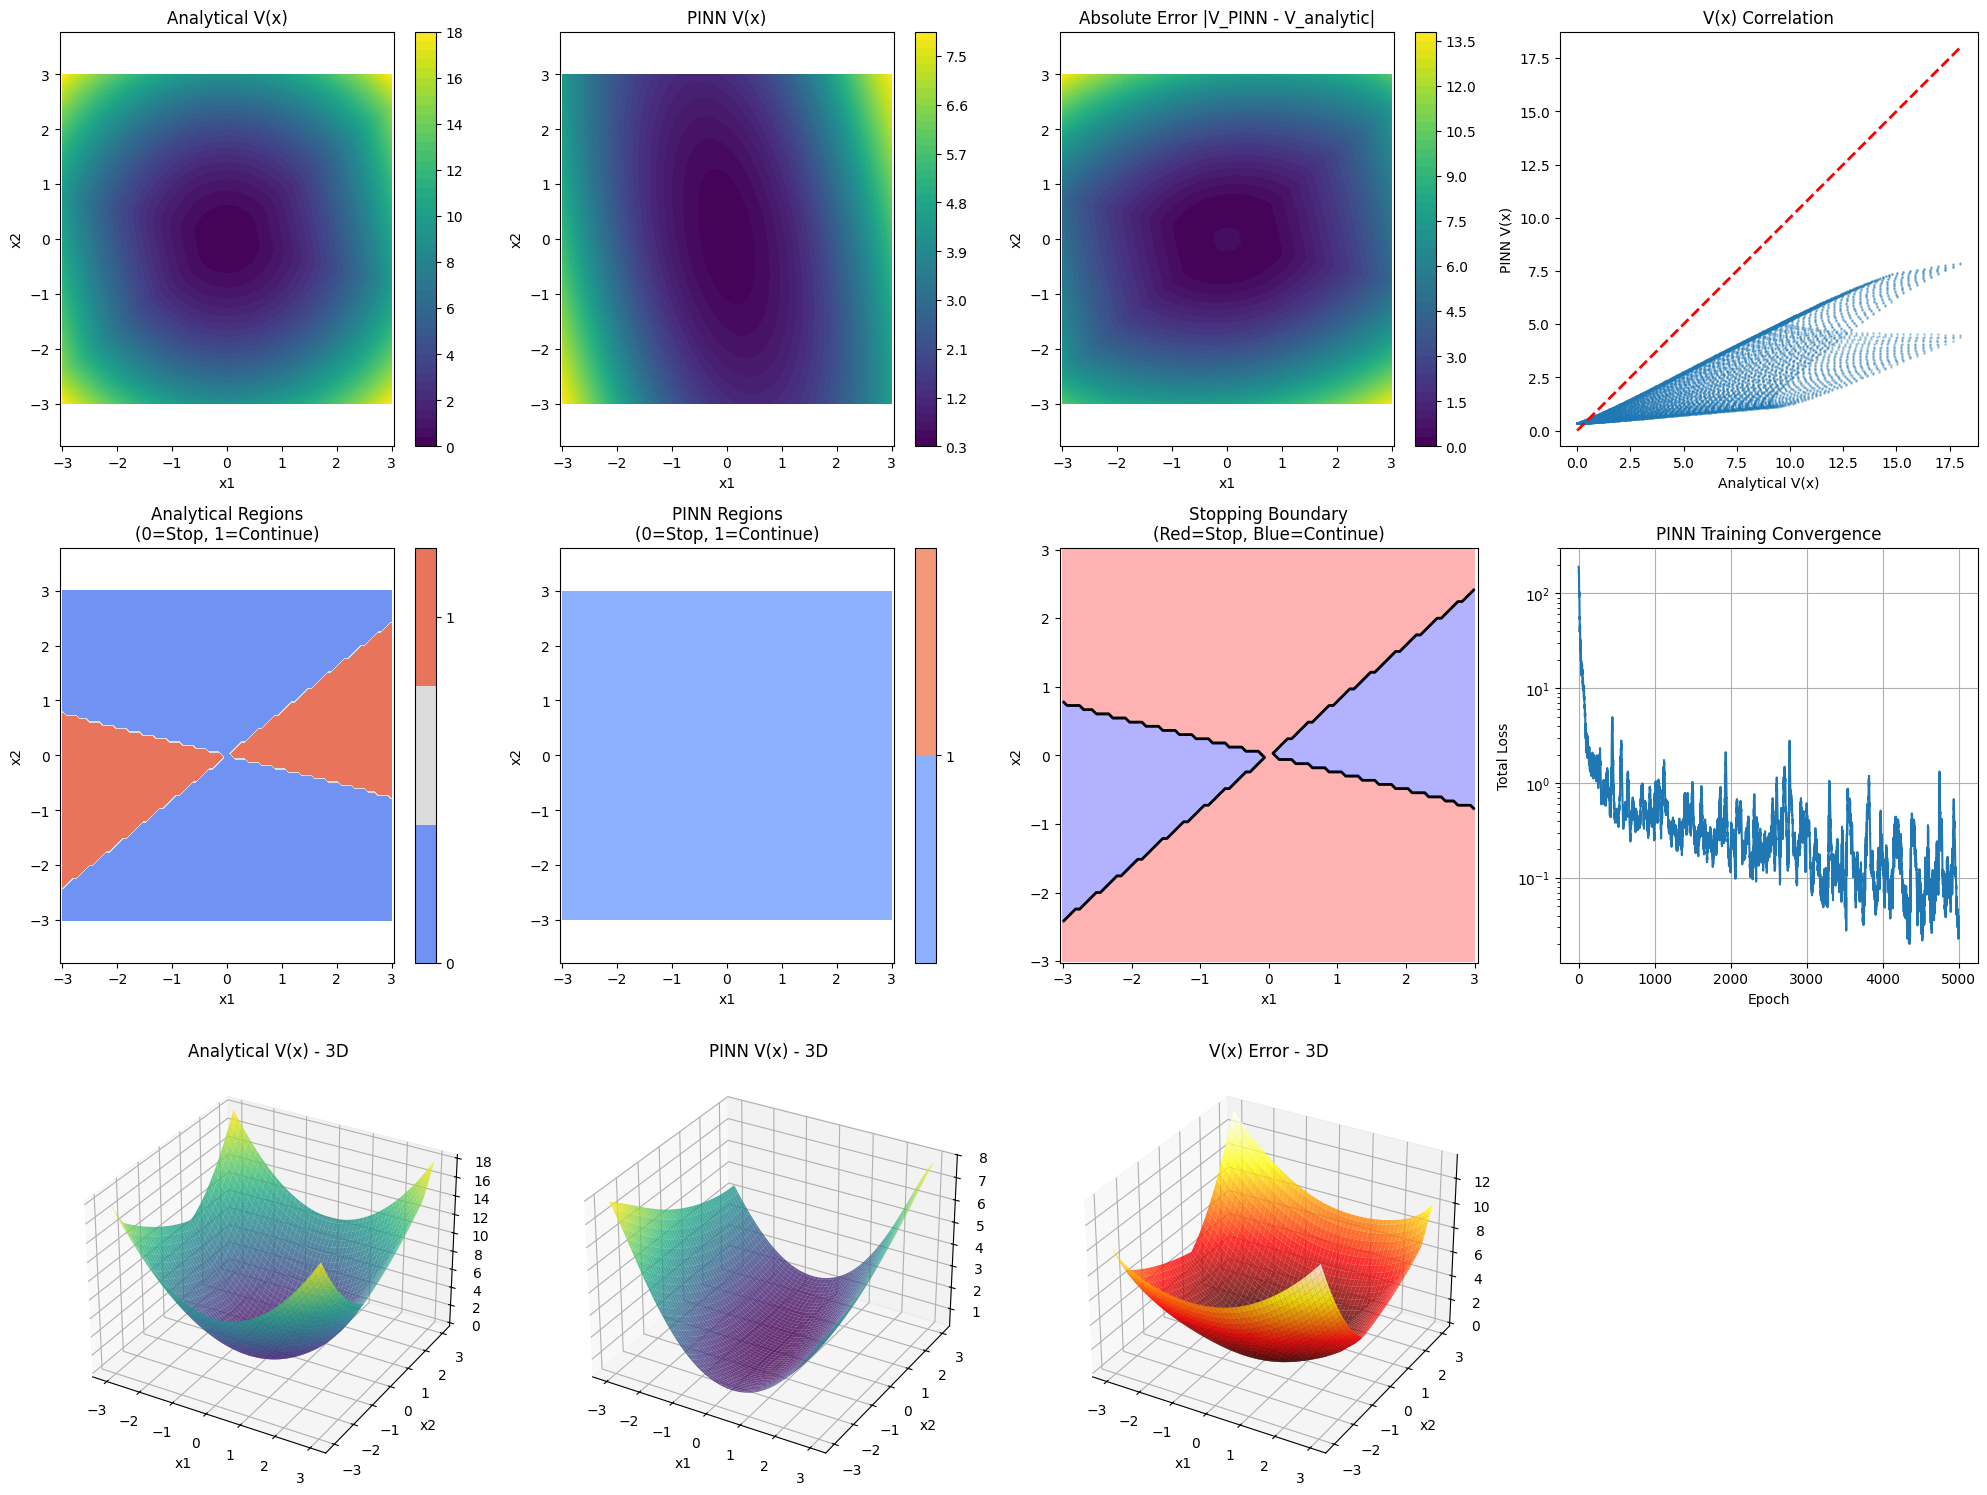


=== QUANTITATIVE COMPARISON METRICS ===
Value Function V(x):
  MAE: 3.950596
  RMSE: 4.796239
  Max Error: 13.620779
  R² Score: -0.492040
Region Classification Accuracy: 0.2636

=== ANALYSIS OF SPECIAL CASES (Part d) ===
=== Analysis of Special Cases ===
S_stop case - Eigenvalues of (P-S): [-0.98996552 -0.99994258]
Interpretation: Both eigenvalues are NEGATIVE → P-S is negative definite
→ xᵀ(P-S)x ≤ 0 for ALL x → Entire space is stopping region
→ Optimal to stop immediately everywhere


S_never case - Eigenvalues of (P-S): [1.01003448 1.00005742]
Interpretation: Both eigenvalues are POSITIVE → P-S is positive definite
→ xᵀ(P-S)x ≥ 0 for ALL x → Entire space is continuation region
→ Never optimal to stop


In [8]:
# First, let's compute the analytical solution for problem 2
print("=== COMPUTING ANALYTICAL SOLUTION FOR PROBLEM 2 ===")
P_analytical = solve_stochastic_riccati(A, B, G, Q, R, rho)
K_analytical = np.linalg.inv(R) @ B.T @ P_analytical

print("Analytical Solution:")
print(f"P = \n{P_analytical}")
print(f"K = {K_analytical.flatten()}")

# Check stopping region
P_minus_S = P_analytical - S
eigvals = np.linalg.eigvals(P_minus_S)
print(f"\nStopping Region Analysis:")
print(f"P - S = \n{P_minus_S}")
print(f"Eigenvalues of (P-S): {eigvals}")
print(f"Stopping region: x such that xᵀ(P-S)x ≤ 0")

# Now run the comparison with PINN results
print("\n=== COMPARING PINN WITH ANALYTICAL SOLUTION ===")
comparison_results = compare_optimal_stopping_solutions(V_net, b_net, P_analytical, S)

# Create comprehensive comparison plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 15))

# 1. Value Function Comparison
plt.subplot(3, 4, 1)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_analytical'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Analytical V(x)')
plt.axis('equal')

plt.subplot(3, 4, 2)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_pinn'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PINN V(x)')
plt.axis('equal')

plt.subplot(3, 4, 3)
contour = plt.contourf(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_error'], levels=50)
plt.colorbar(contour)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Absolute Error |V_PINN - V_analytic|')
plt.axis('equal')

plt.subplot(3, 4, 4)
# Scatter plot of V_analytical vs V_pinn
plt.scatter(comparison_results['V_analytical'].ravel(), 
           comparison_results['V_pinn'].ravel(), alpha=0.3, s=1)
min_val = min(comparison_results['V_analytical'].min(), comparison_results['V_pinn'].min())
max_val = max(comparison_results['V_analytical'].max(), comparison_results['V_pinn'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Analytical V(x)')
plt.ylabel('PINN V(x)')
plt.title('V(x) Correlation')
plt.axis('equal')

# 2. Region Classification Comparison
plt.subplot(3, 4, 5)
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_analytical'], levels=2, cmap='coolwarm')
plt.colorbar(ticks=[0, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Analytical Regions\n(0=Stop, 1=Continue)')
plt.axis('equal')

plt.subplot(3, 4, 6)
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_pinn'], levels=2, cmap='coolwarm')
plt.colorbar(ticks=[0, 1])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PINN Regions\n(0=Stop, 1=Continue)')
plt.axis('equal')

# 3. Stopping Boundary
plt.subplot(3, 4, 7)
# Plot the analytical stopping boundary (where xᵀ(P-S)x = 0)
from matplotlib.colors import ListedColormap
cmap_binary = ListedColormap(['red', 'blue'])
plt.contourf(comparison_results['X1'], comparison_results['X2'], 
            comparison_results['region_analytical'], levels=2, cmap=cmap_binary, alpha=0.3)
# Overlay contour where xᵀ(P-S)x = 0
boundary_contour = plt.contour(comparison_results['X1'], comparison_results['X2'], 
                              comparison_results['region_analytical'], 
                              levels=[0.5], colors='black', linewidths=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Stopping Boundary\n(Red=Stop, Blue=Continue)')
plt.axis('equal')

# 4. Training Convergence
plt.subplot(3, 4, 8)
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('PINN Training Convergence')
plt.grid(True)

# 5. 3D Surface Plots
ax = fig.add_subplot(3, 4, 9, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_analytical'], cmap='viridis', alpha=0.8)
ax.set_title('Analytical V(x) - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(3, 4, 10, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_pinn'], cmap='viridis', alpha=0.8)
ax.set_title('PINN V(x) - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax = fig.add_subplot(3, 4, 11, projection='3d')
surf = ax.plot_surface(comparison_results['X1'], comparison_results['X2'], 
                      comparison_results['V_error'], cmap='hot', alpha=0.8)
ax.set_title('V(x) Error - 3D')
ax.set_xlabel('x1')
ax.set_ylabel('x2')

plt.tight_layout()
plt.show()

# Print quantitative metrics
print("\n=== QUANTITATIVE COMPARISON METRICS ===")
V_analytical_flat = comparison_results['V_analytical'].ravel()
V_pinn_flat = comparison_results['V_pinn'].ravel()
V_error_flat = np.abs(V_pinn_flat - V_analytical_flat)

print(f"Value Function V(x):")
print(f"  MAE: {np.mean(V_error_flat):.6f}")
print(f"  RMSE: {np.sqrt(np.mean(V_error_flat**2)):.6f}")
print(f"  Max Error: {np.max(V_error_flat):.6f}")
print(f"  R² Score: {1 - np.sum(V_error_flat**2) / np.sum((V_analytical_flat - np.mean(V_analytical_flat))**2):.6f}")

region_accuracy = np.mean(comparison_results['region_pinn'].ravel() == comparison_results['region_analytical'].ravel())
print(f"Region Classification Accuracy: {region_accuracy:.4f}")

# Analyze the special cases for part (d)
print("\n=== ANALYSIS OF SPECIAL CASES (Part d) ===")
analyze_special_cases()

In [ ]:
def solve_stochastic_riccati(A, B, R, Q, G, rho, max_iter=1000, tol=1e-10):
    """Solve the stochastic Riccati equation iteratively
    AᵀP + PA - PBR⁻¹BᵀP + Q - ρP + PGGᵀP = 0
    """
    n = A.shape[0]
    P = Q.copy()  # Initial guess
    GGT = G @ G.T
    
    for i in range(max_iter):
        # Rearrange as: AᵀP + PA - PBR⁻¹BᵀP + (Q - ρP + PGGᵀP) = 0
        # Treat (Q - ρP + PGGᵀP) as the "effective Q" for this iteration
        Q_eff = Q - rho * P + P @ GGT @ P
        
        # Solve standard CARE with effective Q
        P_new = solve_continuous_are(A, B, Q_eff, R)
        
        # Check convergence
        if np.linalg.norm(P_new - P, 'fro') < tol:
            print(f"Converged after {i+1} iterations")
            return P_new
        
        P = P_new
    
    print(f"Warning: Did not converge after {max_iter} iterations")
    return P

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- Problem Parameters from the document ---
rho = 0.1
A = torch.tensor([[0., 1.], [-2., -3.]], dtype=torch.float32)
B = torch.tensor([[0.], [1.]], dtype=torch.float32)
G = torch.tensor([[0.1, 0.], [0., 0.1]], dtype=torch.float32)
Q = torch.eye(2, dtype=torch.float32)
R = torch.tensor([[1.]], dtype=torch.float32)
S = torch.eye(2, dtype=torch.float32) # S = I_2 as per problem spec [cite: 55]

# Pre-calculate for efficiency
R_inv = torch.inverse(R)
GGt = G @ G.T

# --- Neural Network Definition ---
class ValueFunctionNN(nn.Module):
    def __init__(self, n_input=2, n_output=1, n_hidden=64):
        super(ValueFunctionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_input, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_output)
        )
    def forward(self, x):
        return self.network(x)

# Instantiate the network and optimizer
V_net = ValueFunctionNN()
optimizer = torch.optim.Adam(V_net.parameters(), lr=1e-3)

In [10]:
# --- Training Loop ---
epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Generate a batch of random collocation points
    x = (torch.rand(512, 2, dtype=torch.float32) - 0.5) * 6 # Sample in [-3, 3]
    x.requires_grad_(True)

    # Compute V(x) and its derivatives
    V = V_net(x)
    grad_V = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    
    tr_term = 0.0
    for i in range(2):
        grad_V_i = grad_V[:, i:i+1]
        hessian_row_i = torch.autograd.grad(grad_V_i, x, grad_outputs=torch.ones_like(grad_V_i), create_graph=True)[0]
        tr_term += GGt[i, i] * hessian_row_i[:, i]
    tr_term = tr_term.unsqueeze(1)

    # --- Construct the Loss Function for the Variational Inequality ---
    
    # 1. HJB Residual (L1)
    xQx = torch.sum(x @ Q * x, dim=1, keepdim=True)
    gradV_Ax = torch.sum(grad_V * (x @ A.T), dim=1, keepdim=True)
    gradV_BRB_gradV = torch.sum((grad_V @ B @ R_inv) * (grad_V @ B), dim=1, keepdim=True)
    
    hjb_residual = rho * V - (xQx + gradV_Ax - gradV_BRB_gradV + 0.5 * tr_term)

    # 2. Stopping Residual (L2)
    xSx = torch.sum(x @ S * x, dim=1, keepdim=True)
    stopping_residual = V - xSx
    
    # 3. Combine into final loss
    # We enforce L1 >= 0, L2 >= 0, and L1 * L2 = 0
    loss_continuation = torch.mean(torch.relu(-hjb_residual))
    loss_stopping_ge = torch.mean(torch.relu(-stopping_residual))
    loss_complementarity = torch.mean(hjb_residual * stopping_residual)
    
    loss = loss_continuation + loss_stopping_ge + loss_complementarity

    # Backpropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("Training finished.")

Epoch [1000/20000], Loss: -1612642.875000
Epoch [2000/20000], Loss: -28767004.000000
Epoch [3000/20000], Loss: -48539208.000000
Epoch [4000/20000], Loss: -243189904.000000
Epoch [5000/20000], Loss: -227698128.000000
Epoch [6000/20000], Loss: -480958272.000000
Epoch [7000/20000], Loss: -500150080.000000
Epoch [8000/20000], Loss: -436350208.000000
Epoch [9000/20000], Loss: -1705334400.000000
Epoch [10000/20000], Loss: -967623104.000000
Epoch [11000/20000], Loss: -2558364928.000000
Epoch [12000/20000], Loss: -2044926336.000000
Epoch [13000/20000], Loss: -6182420480.000000
Epoch [14000/20000], Loss: -14426229760.000000
Epoch [15000/20000], Loss: -8157042688.000000
Epoch [16000/20000], Loss: -6442670080.000000
Epoch [17000/20000], Loss: -16558266368.000000
Epoch [18000/20000], Loss: -11468798976.000000
Epoch [19000/20000], Loss: -4607629824.000000
Epoch [20000/20000], Loss: -30155368448.000000
Training finished.


In [12]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

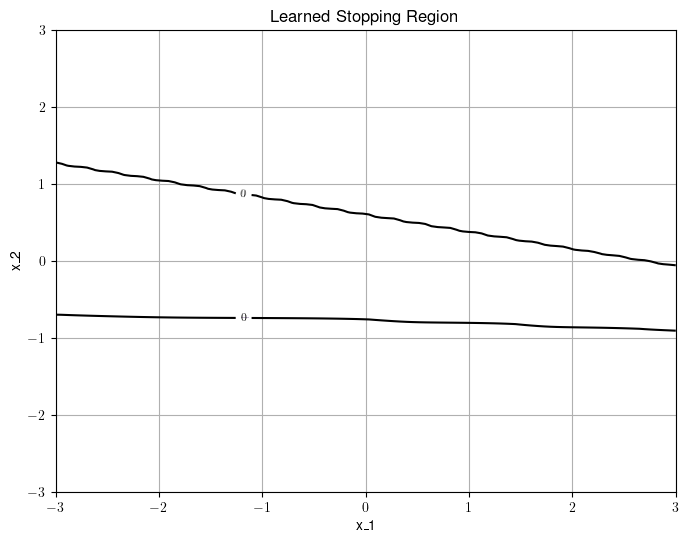

In [14]:
# Create a grid of points to evaluate the network
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
x_grid = np.vstack([X1.ravel(), X2.ravel()]).T
x_grid_torch = torch.tensor(x_grid, dtype=torch.float32)

# Calculate V_hat and the stopping residual on the grid
V_hat = V_net(x_grid_torch).detach().numpy()
xSx = np.sum((x_grid @ S.numpy()) * x_grid, axis=1)
stopping_residual_grid = V_hat.flatten() - xSx

# The stopping region is where V_hat ≈ xSx, or stopping_residual ≈ 0
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, stopping_residual_grid.reshape(X1.shape), levels=[-0.1, 0.01], colors=['#8d75a3'], alpha=0.5)
contour = plt.contour(X1, X2, stopping_residual_grid.reshape(X1.shape), levels=[0], colors='black')
plt.clabel(contour, inline=True, fontsize=8)
plt.title('Learned Stopping Region')
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.grid(True)
plt.show()

# The area shaded in purple is the learned stopping region S
# The black line is the learned stopping boundary b(x)

<>:113: SyntaxWarning: invalid escape sequence '\h'
<>:116: SyntaxWarning: invalid escape sequence '\h'
<>:121: SyntaxWarning: invalid escape sequence '\h'
<>:113: SyntaxWarning: invalid escape sequence '\h'
<>:116: SyntaxWarning: invalid escape sequence '\h'
<>:121: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\535615938.py:113: SyntaxWarning: invalid escape sequence '\h'
  ax2.set_title('PINN Value Function $\hat{V}(x)$', fontsize=16)
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\535615938.py:116: SyntaxWarning: invalid escape sequence '\h'
  ax2.set_zlabel('$\hat{V}(x)$')
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\535615938.py:121: SyntaxWarning: invalid escape sequence '\h'
  ax3.set_title('Absolute Error |V(x) - $\hat{V}(x)$|', fontsize=16)


--- Analytical Solution ---
P matrix:
[[1.14817499 0.2102449 ]
 [0.2102449  0.22459765]]
c constant: 0.1373

--- Training PINN ---
Epoch [2000/10000], Loss: 0.008806
Epoch [4000/10000], Loss: 0.001030
Epoch [6000/10000], Loss: 0.000709
Epoch [8000/10000], Loss: 0.002486
Epoch [10000/10000], Loss: 0.000460
Training finished.



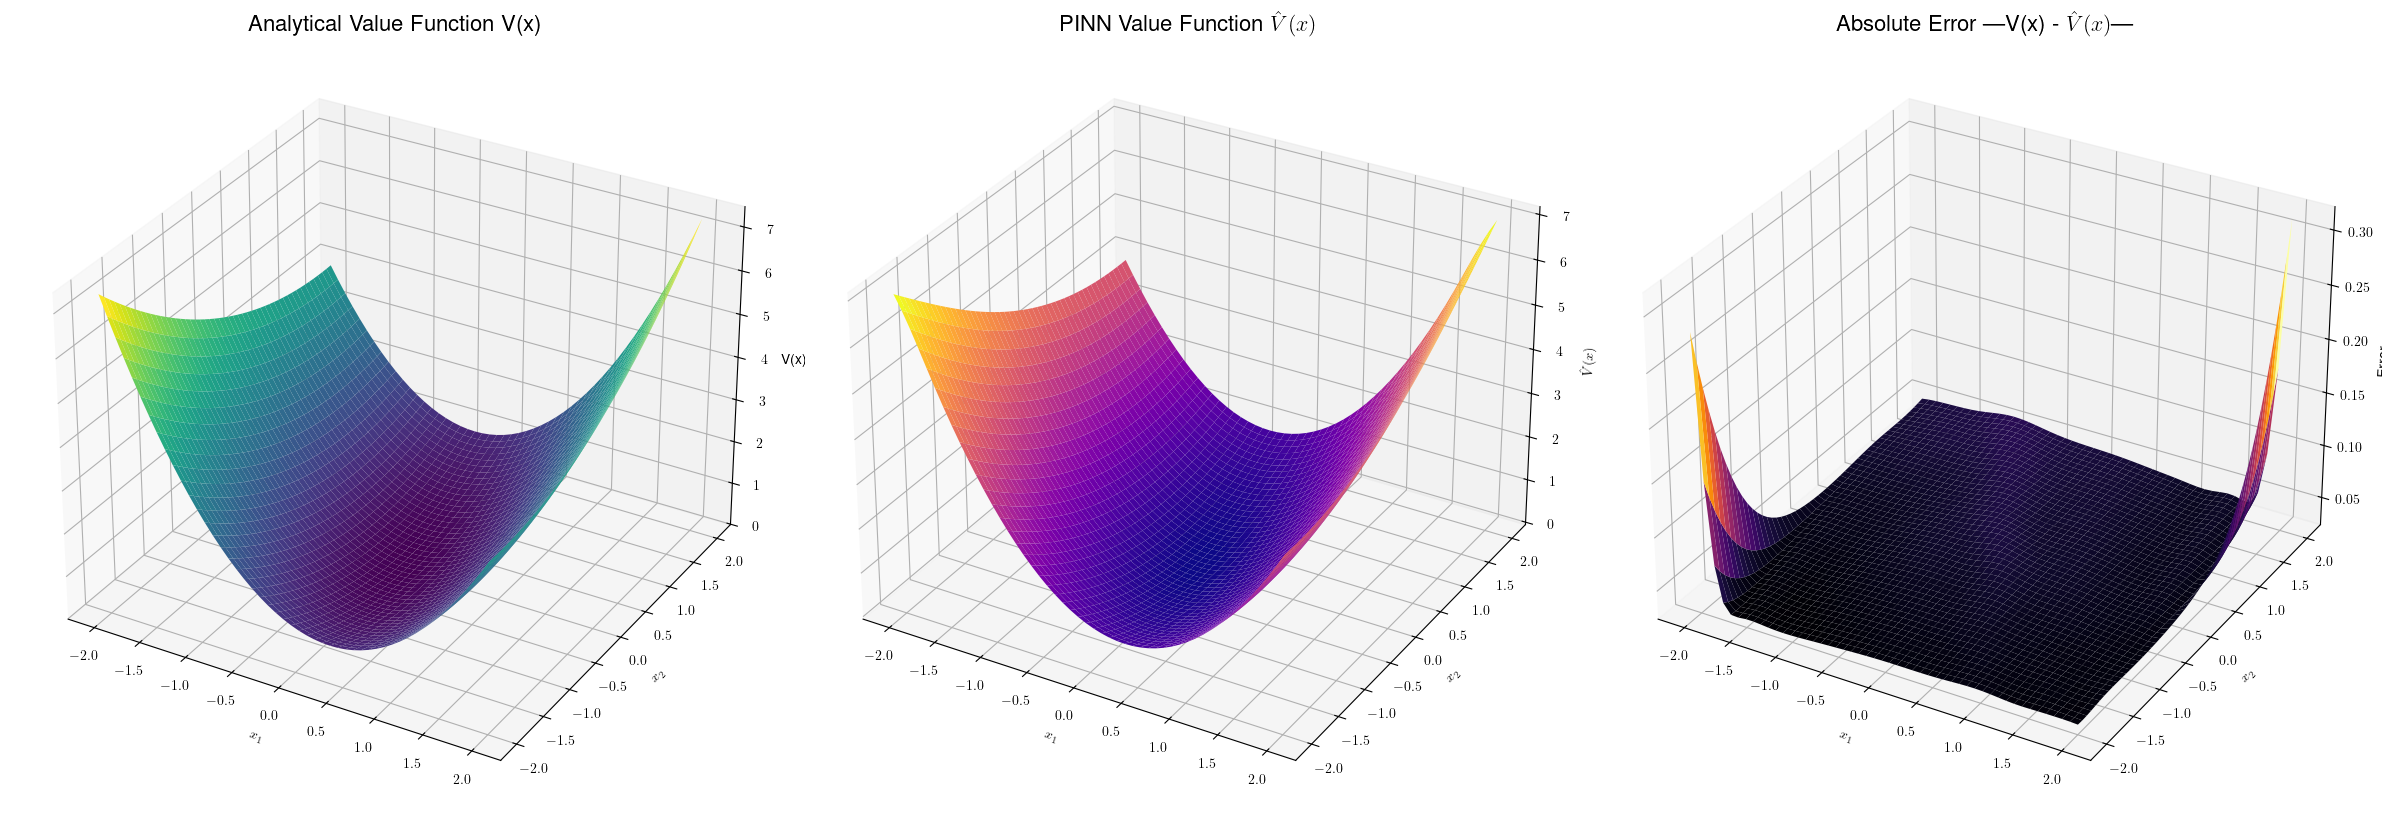

In [16]:
# --- Problem Parameters (as Tensors for PyTorch and NumPy for SciPy) ---
rho = 0.1
A_np = np.array([[0.0, 1.0], [-2.0, -3.0]])
B_np = np.array([[0.0], [1.0]])
G_np = np.array([[0.1, 0.0], [0.0, 0.1]])
Q_np = np.eye(2)
R_np = np.array([[1.0]])

A_torch = torch.tensor(A_np, dtype=torch.float32)
B_torch = torch.tensor(B_np, dtype=torch.float32)
G_torch = torch.tensor(G_np, dtype=torch.float32)
Q_torch = torch.tensor(Q_np, dtype=torch.float32)
R_torch = torch.tensor(R_np, dtype=torch.float32)
R_inv_torch = torch.inverse(R_torch)
GGt_torch = G_torch @ G_torch.T

# --- Step 1: Compute the Analytical Solution ---
# We need to solve: A'P + PA - PBR⁻¹B'P + Q - ρP = 0
# We can modify it to use a standard CARE solver:
# (A - ρ/2*I)'P + P(A - ρ/2*I) - PBR⁻¹B'P + Q = 0
A_tilde = A_np - (rho / 2) * np.eye(A_np.shape[0])
P_analytical = solve_continuous_are(A_tilde, B_np, Q_np, R_np)
c_analytical = np.trace(P_analytical @ G_np @ G_np.T) / rho

def analytical_value_function(x):
    # V(x) = x'Px + c
    x_vec = x.reshape(-1, 1)
    return (x_vec.T @ P_analytical @ x_vec + c_analytical).item()

print("--- Analytical Solution ---")
print(f"P matrix:\n{P_analytical}")
print(f"c constant: {c_analytical:.4f}\n")


# --- Step 2: Define and Train the PINN ---

class ValueFunctionNN(nn.Module):
    def __init__(self, n_input=2, n_output=1, n_hidden=64):
        super(ValueFunctionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_input, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_output)
        )
    def forward(self, x):
        return self.network(x)

V_net = ValueFunctionNN()
optimizer = torch.optim.Adam(V_net.parameters(), lr=1e-3)

print("--- Training PINN ---")
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    x = (torch.rand(256, 2, dtype=torch.float32) - 0.5) * 4
    x.requires_grad_(True)

    V = V_net(x)
    grad_V = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    
    tr_term = 0.0
    for i in range(2):
        grad_V_i = grad_V[:, i:i+1]
        hessian_row_i = torch.autograd.grad(grad_V_i, x, grad_outputs=torch.ones_like(grad_V_i), create_graph=True)[0]
        tr_term += GGt_torch[i, i] * hessian_row_i[:, i]
    tr_term = tr_term.unsqueeze(1)

    xQx = torch.sum(x @ Q_torch * x, dim=1, keepdim=True)
    gradV_Ax = torch.sum(grad_V * (x @ A_torch.T), dim=1, keepdim=True)
    gradV_BRB_gradV = torch.sum((grad_V @ B_torch @ R_inv_torch) * (grad_V @ B_torch), dim=1, keepdim=True)
    
    hjb_residual = xQx + gradV_Ax - 0.25 * gradV_BRB_gradV + 0.5 * tr_term - rho * V
    loss = torch.mean(hjb_residual**2)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
print("Training finished.\n")


# --- Step 3: Compare and Visualize the Solutions ---

# Create a grid of points for plotting
x1 = np.linspace(-2, 2, 50)
x2 = np.linspace(-2, 2, 50)
X1, X2 = np.meshgrid(x1, x2)
x_grid_np = np.vstack([X1.ravel(), X2.ravel()]).T
x_grid_torch = torch.tensor(x_grid_np, dtype=torch.float32)

# Evaluate both solutions on the grid
V_analytical_grid = np.array([analytical_value_function(x) for x in x_grid_np]).reshape(X1.shape)
V_pinn_grid = V_net(x_grid_torch).detach().numpy().reshape(X1.shape)

# Calculate absolute error
error = np.abs(V_pinn_grid - V_analytical_grid)

# Plotting
fig = plt.figure(figsize=(24, 8))

# Plot Analytical Solution
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, V_analytical_grid, cmap='viridis')
ax1.set_title('Analytical Value Function V(x)', fontsize=16)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('V(x)')

# Plot PINN Solution
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, V_pinn_grid, cmap='plasma')
ax2.set_title('PINN Value Function $\hat{V}(x)$', fontsize=16)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_zlabel('$\hat{V}(x)$')

# Plot Absolute Error
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1, X2, error, cmap='inferno')
ax3.set_title('Absolute Error |V(x) - $\hat{V}(x)$|', fontsize=16)
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$')
ax3.set_zlabel('Error')

plt.tight_layout()
plt.show()

<>:144: SyntaxWarning: invalid escape sequence '\h'
<>:149: SyntaxWarning: invalid escape sequence '\h'
<>:167: SyntaxWarning: invalid escape sequence '\h'
<>:144: SyntaxWarning: invalid escape sequence '\h'
<>:149: SyntaxWarning: invalid escape sequence '\h'
<>:167: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\4222733420.py:144: SyntaxWarning: invalid escape sequence '\h'
  ax2.set_title('PINN Value Function $\hat{V}(x)$', fontsize=16)
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\4222733420.py:149: SyntaxWarning: invalid escape sequence '\h'
  ax3.set_title('Absolute Error |V(x) - $\hat{V}(x)$|', fontsize=16)
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\4222733420.py:167: SyntaxWarning: invalid escape sequence '\h'
  plt.legend(['Analytical Boundary ($x^T(P-S)x=0$)', 'PINN Boundary ($\hat{V}(x)-x^TSx=0$)'])


Analytical solver converged in 5 iterations.
--- Analytical Solution ---
P matrix:
[[1.15725402 0.21316998]
 [0.21316998 0.22563788]]

--- Training PINN ---
Epoch [2000/20000], Loss: -11160436.000000
Epoch [4000/20000], Loss: -80030520.000000
Epoch [6000/20000], Loss: -276683904.000000
Epoch [8000/20000], Loss: -816728576.000000
Epoch [10000/20000], Loss: -322144896.000000
Epoch [12000/20000], Loss: -1653929472.000000
Epoch [14000/20000], Loss: -3018407424.000000
Epoch [16000/20000], Loss: -6653420544.000000
Epoch [18000/20000], Loss: -2911503360.000000
Epoch [20000/20000], Loss: -6973979648.000000
Training finished.



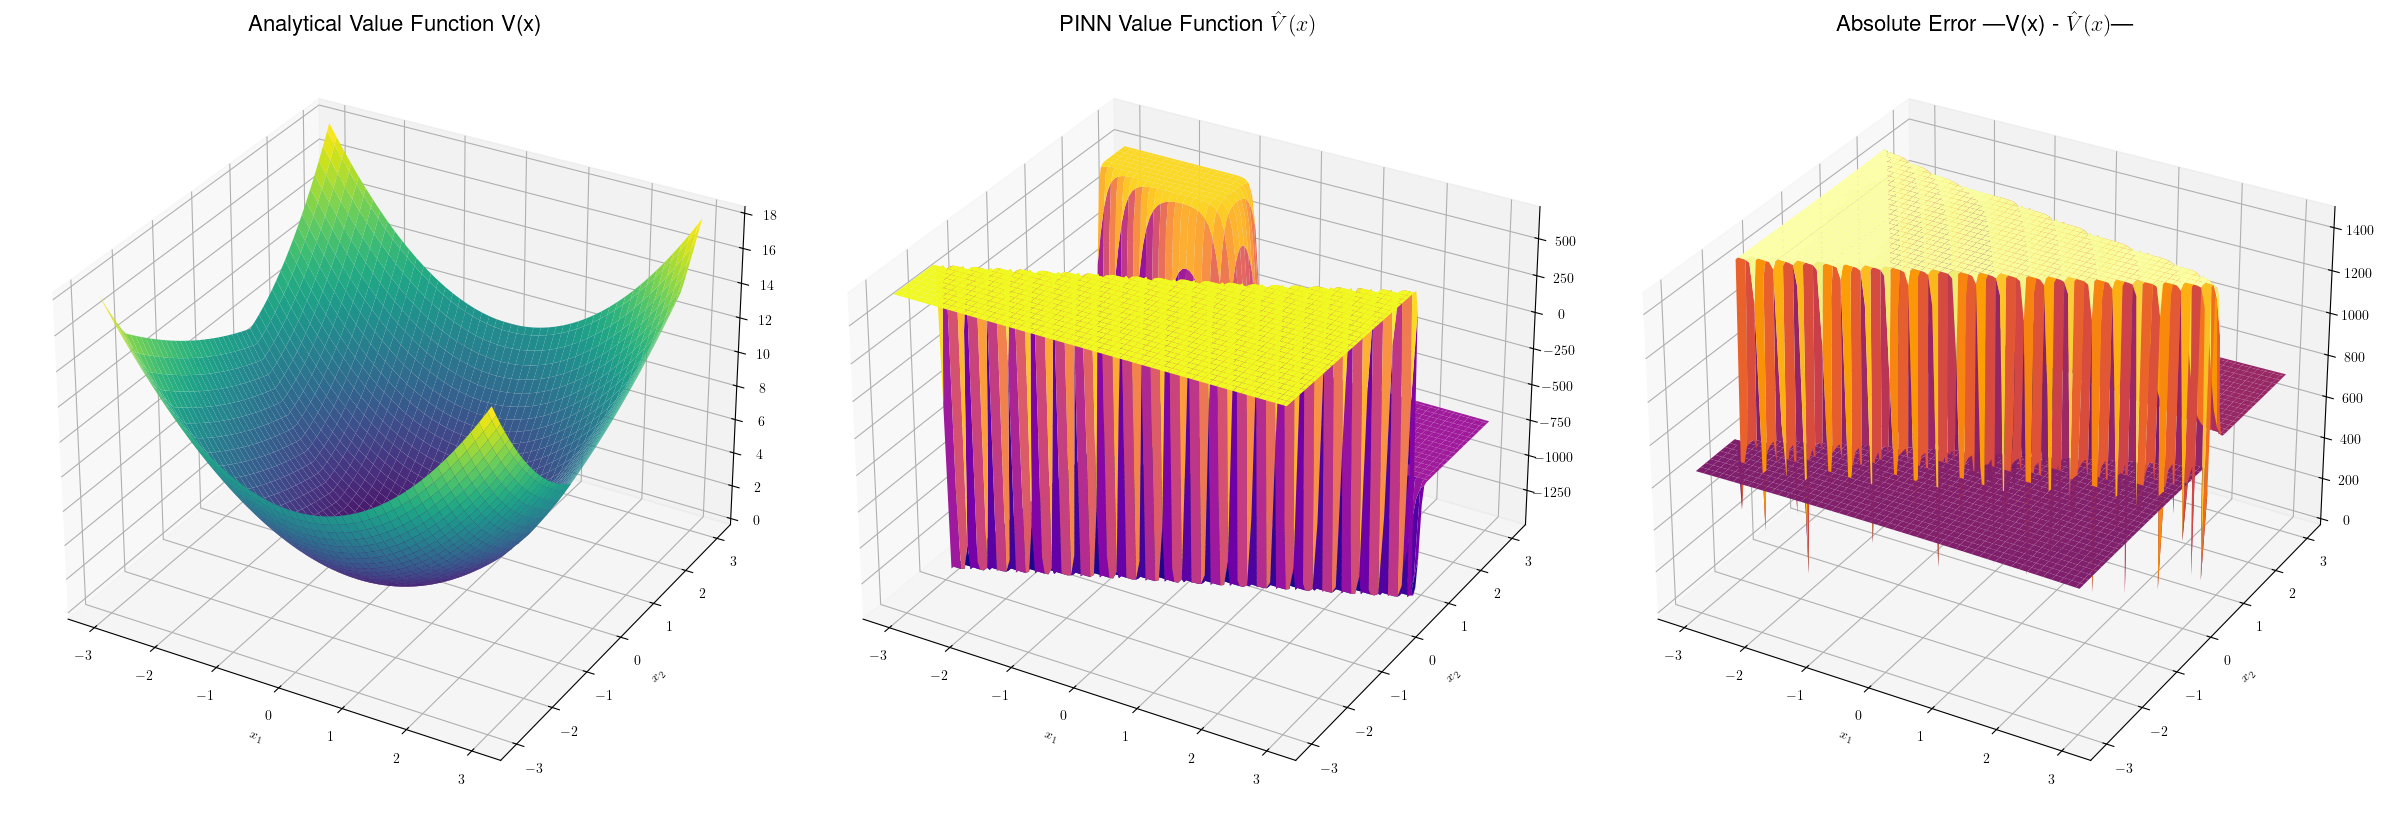

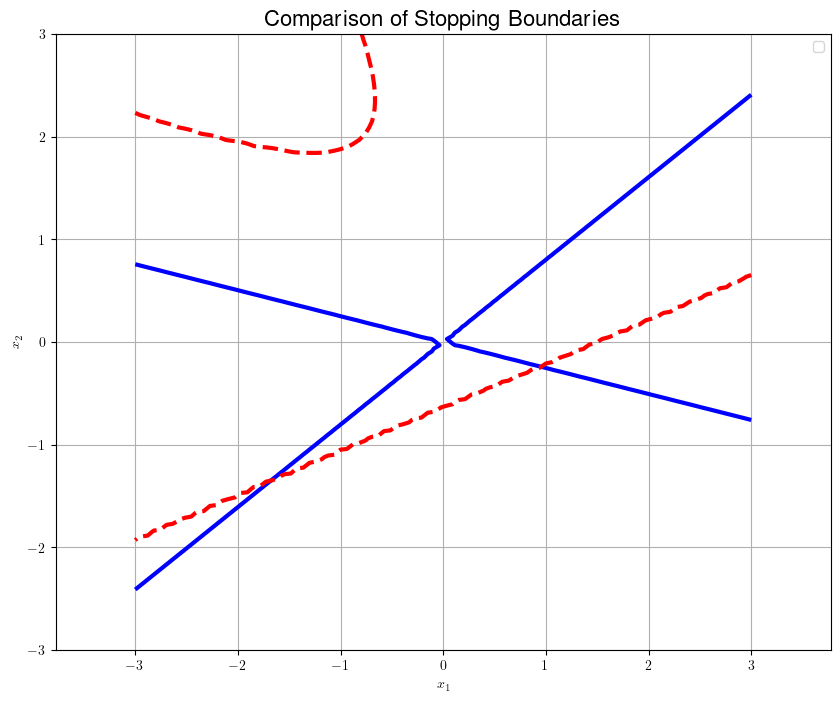

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import solve_lyapunov

# --- Problem Parameters ---
rho = 0.1
A_np = np.array([[0.0, 1.0], [-2.0, -3.0]])
B_np = np.array([[0.0], [1.0]])
G_np = np.array([[0.1, 0.0], [0.0, 0.1]])
Q_np = np.eye(2)
R_np = np.array([[1.0]])
S_np = np.eye(2) # Stopping cost matrix S = I_2

A_torch = torch.tensor(A_np, dtype=torch.float32)
B_torch = torch.tensor(B_np, dtype=torch.float32)
G_torch = torch.tensor(G_np, dtype=torch.float32)
Q_torch = torch.tensor(Q_np, dtype=torch.float32)
R_torch = torch.tensor(R_np, dtype=torch.float32)
S_torch = torch.tensor(S_np, dtype=torch.float32)
R_inv_torch = torch.inverse(R_torch)
GGt_torch = G_torch @ G_torch.T


# --- Step 1: Compute the Analytical Solution ---

def solve_stochastic_riccati_iteratively(A, B, G, Q, R, rho, max_iter=50, tol=1e-8):
    """Solves the stochastic Riccati equation using Newton's method."""
    n = A.shape[0]
    I = np.eye(n)
    S_mat = B @ np.linalg.inv(R) @ B.T - G @ G.T
    
    # Initial guess (from deterministic CARE)
    P_k = np.eye(n) # A simple initial guess can also work
    
    for i in range(max_iter):
        P_prev = P_k.copy()
        A_k = A - S_mat @ P_k
        A_lyap = A_k - (rho / 2) * I
        Q_lyap = P_k @ S_mat @ P_k + Q
        
        P_k = solve_lyapunov(A_lyap.T, -Q_lyap)
        
        if np.linalg.norm(P_k - P_prev) < tol:
            print(f"Analytical solver converged in {i+1} iterations.")
            return P_k
    print("Analytical solver did not converge.")
    return P_k

P_analytical = solve_stochastic_riccati_iteratively(A_np, B_np, G_np, Q_np, R_np, rho)

def analytical_value_function(x, P, S):
    # V(x) = max(x'Px, x'Sx) because P must dominate S in the continuation region
    x_vec = x.reshape(-1, 1)
    v_continue = (x_vec.T @ P @ x_vec).item()
    v_stop = (x_vec.T @ S @ x_vec).item()
    return max(v_continue, v_stop)

print("--- Analytical Solution ---")
print(f"P matrix:\n{P_analytical}\n")


# --- Step 2: Define and Train the PINN ---

class ValueFunctionNN(nn.Module):
    def __init__(self, n_input=2, n_output=1, n_hidden=64):
        super(ValueFunctionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_input, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_hidden), nn.Tanh(),
            nn.Linear(n_hidden, n_output)
        )
    def forward(self, x):
        return self.network(x)

V_net = ValueFunctionNN()
optimizer = torch.optim.Adam(V_net.parameters(), lr=1e-3)

print("--- Training PINN ---")
epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()
    x = (torch.rand(512, 2, dtype=torch.float32) - 0.5) * 6
    x.requires_grad_(True)

    V = V_net(x)
    grad_V = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    
    tr_term = 0.0
    for i in range(2):
        grad_V_i = grad_V[:, i:i+1]
        hessian_row_i = torch.autograd.grad(grad_V_i, x, grad_outputs=torch.ones_like(grad_V_i), create_graph=True)[0]
        tr_term += GGt_torch[i, i] * hessian_row_i[:, i]
    tr_term = tr_term.unsqueeze(1)

    xQx = torch.sum(x @ Q_torch * x, dim=1, keepdim=True)
    gradV_Ax = torch.sum(grad_V * (x @ A_torch.T), dim=1, keepdim=True)
    gradV_BRB_gradV = torch.sum((grad_V @ B_torch @ R_inv_torch) * (grad_V @ B_torch), dim=1, keepdim=True)
    
    hjb_residual = rho * V - (xQx + gradV_Ax - gradV_BRB_gradV + 0.5 * tr_term)
    
    xSx = torch.sum(x @ S_torch * x, dim=1, keepdim=True)
    stopping_residual = V - xSx
    
    loss_continuation = torch.mean(torch.relu(-hjb_residual))
    loss_stopping_ge = torch.mean(torch.relu(-stopping_residual))
    loss_complementarity = torch.mean(hjb_residual * stopping_residual)
    
    loss = loss_continuation + loss_stopping_ge + loss_complementarity
    
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 2000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')
print("Training finished.\n")


# --- Step 3: Compare and Visualize the Solutions ---

# Create a grid of points for plotting
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
x_grid_np = np.vstack([X1.ravel(), X2.ravel()]).T
x_grid_torch = torch.tensor(x_grid_np, dtype=torch.float32)

# Evaluate both solutions on the grid
V_analytical_grid = np.array([analytical_value_function(x, P_analytical, S_np) for x in x_grid_np]).reshape(X1.shape)
V_pinn_grid = V_net(x_grid_torch).detach().numpy().reshape(X1.shape)
error = np.abs(V_pinn_grid - V_analytical_grid)

# Plotting 3D Surfaces
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, V_analytical_grid, cmap='viridis')
ax1.set_title('Analytical Value Function V(x)', fontsize=16)
ax1.set_xlabel('$x_1$'); ax1.set_ylabel('$x_2$')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, V_pinn_grid, cmap='plasma')
ax2.set_title('PINN Value Function $\hat{V}(x)$', fontsize=16)
ax2.set_xlabel('$x_1$'); ax2.set_ylabel('$x_2$')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1, X2, error, cmap='inferno')
ax3.set_title('Absolute Error |V(x) - $\hat{V}(x)$|', fontsize=16)
ax3.set_xlabel('$x_1$'); ax3.set_ylabel('$x_2$')
plt.tight_layout()
plt.show()


# Plotting 2D Stopping Boundaries
plt.figure(figsize=(10, 8))
# Analytical boundary: where x'(P-S)x = 0
analytical_boundary = (x_grid_np @ (P_analytical - S_np) * x_grid_np).sum(axis=1)
plt.contour(X1, X2, analytical_boundary.reshape(X1.shape), levels=[0], colors='blue', linewidths=3)

# PINN boundary: where V_hat(x) - x'Sx = 0
pinn_boundary = V_pinn_grid.flatten() - (x_grid_np @ S_np * x_grid_np).sum(axis=1)
plt.contour(X1, X2, pinn_boundary.reshape(X1.shape), levels=[0], colors='red', linestyles='--', linewidths=3)

plt.title('Comparison of Stopping Boundaries', fontsize=16)
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.legend(['Analytical Boundary ($x^T(P-S)x=0$)', 'PINN Boundary ($\hat{V}(x)-x^TSx=0$)'])
plt.grid(True)
plt.axis('equal')
plt.show()

In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import torch.optim as optim
from torch.autograd import grad

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.eye(2)
R = np.array([[1]])
S = np.eye(2)  # Stopping cost matrix

# Analytical solution for stochastic optimal stopping LQR
def solve_stochastic_optimal_stopping():
    # Solve the stochastic Riccati equation: A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
    # We'll use iterative method to solve this nonlinear equation
    P_old = np.eye(2)
    tolerance = 1e-8
    max_iter = 1000
    
    for i in range(max_iter):
        # Fixed-point iteration
        A_modified = A - 0.5 * rho * np.eye(2) + 0.5 * G @ G.T @ P_old
        P_new = solve_continuous_are(A_modified, B, Q, R)
        
        if np.max(np.abs(P_new - P_old)) < tolerance:
            break
        P_old = P_new
    
    P = P_new
    
    # Optimal control gain
    K = np.linalg.solve(R, B.T @ P)
    
    # Stopping boundary: {x: x^T P x = x^T S x} or {x: x^T (P - S) x = 0}
    stopping_boundary_matrix = P - S
    
    return P, K, stopping_boundary_matrix

# Compute analytical solution
P_analytical, K_analytical, boundary_matrix = solve_stochastic_optimal_stopping()
print("Analytical solution:")
print("P =", P_analytical)
print("K =", K_analytical)
print("Stopping boundary matrix (P-S) =", boundary_matrix)

# Neural Network for Value Function V(x)
class ValueNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(ValueNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Neural Network for Stopping Boundary b(x)
class BoundaryNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(BoundaryNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# PINN for Stochastic Optimal Stopping LQR
class StochasticOptimalStoppingPINN:
    def __init__(self):
        self.V_net = ValueNetwork()
        self.b_net = BoundaryNetwork()
        self.optimizer = optim.Adam(
            list(self.V_net.parameters()) + list(self.b_net.parameters()), 
            lr=1e-3
        )
        
        # Convert numpy arrays to torch tensors
        self.A = torch.tensor(A, dtype=torch.float32)
        self.B = torch.tensor(B, dtype=torch.float32)
        self.G = torch.tensor(G, dtype=torch.float32)
        self.Q = torch.tensor(Q, dtype=torch.float32)
        self.R = torch.tensor(R, dtype=torch.float32)
        self.S = torch.tensor(S, dtype=torch.float32)
        self.rho = torch.tensor(rho, dtype=torch.float32)
        
    def compute_derivatives(self, x, model, training=True):
        """Compute first and second derivatives of model output w.r.t. input x"""
        x.requires_grad_(True)
        
        # First derivative
        u = model(x)
        du_dx = grad(u, x, grad_outputs=torch.ones_like(u), 
                    create_graph=training, retain_graph=training)[0]
        
        # Second derivative (Hessian diagonal approximation)
        d2u_dx2 = []
        for i in range(x.shape[1]):
            du_dxi = grad(du_dx[:, i], x, grad_outputs=torch.ones_like(du_dx[:, i]),
                         create_graph=training, retain_graph=training)[0][:, i]
            d2u_dx2.append(du_dxi.unsqueeze(1))
        
        d2u_dx2 = torch.cat(d2u_dx2, dim=1)
        
        return u, du_dx, d2u_dx2
    
    def physics_loss(self, x):
        """Compute physics-informed loss for the HJB variational inequality"""
        # Compute value function and its derivatives
        V, dV_dx, d2V_dx2 = self.compute_derivatives(x, self.V_net)
        
        # Optimal control
        u_opt = -torch.linalg.solve(self.R, self.B.T @ dV_dx.T).T
        
        # Hamiltonian term
        xQx = torch.sum(x @ self.Q * x, dim=1, keepdim=True)
        uRu = torch.sum(u_opt @ self.R * u_opt, dim=1, keepdim=True)
        
        Ax_Bu = x @ self.A.T + u_opt @ self.B.T
        drift_term = torch.sum(dV_dx * Ax_Bu, dim=1, keepdim=True)
        
        # Diffusion term
        GGt = self.G @ self.G.T
        diffusion_term = 0.5 * torch.trace(GGt) * torch.sum(d2V_dx2, dim=1, keepdim=True)
        
        # HJB residual in continuation region
        hjb_residual = self.rho * V - (xQx + uRu + drift_term + diffusion_term)
        
        # Boundary condition: V(x) - x^T S x
        boundary_condition = V - torch.sum(x @ self.S * x, dim=1, keepdim=True)
        
        # Boundary network output
        b_output = self.b_net(x)
        
        # Variational inequality loss
        # min{ρV - HJB, V - x^T S x} = 0
        loss_continuation = torch.mean(torch.relu(b_output) * hjb_residual**2)
        loss_stopping = torch.mean(torch.relu(-b_output) * boundary_condition**2)
        loss_smooth = torch.mean((torch.abs(b_output)) * (hjb_residual - boundary_condition)**2)
        
        total_loss = loss_continuation + loss_stopping + loss_smooth
        
        return total_loss, V, u_opt, b_output
    
    def train(self, n_epochs=5000, n_points=1000):
        """Train the PINN"""
        losses = []
        
        for epoch in range(n_epochs):
            # Sample training points
            x_train = torch.randn(n_points, 2) * 2.0  # Sample from wider distribution
            
            self.optimizer.zero_grad()
            loss, _, _, _ = self.physics_loss(x_train)
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
            if epoch % 500 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        
        return losses
    
    def predict(self, x):
        """Predict value function, control, and boundary"""
        # We need to compute gradients for the derivatives, so we enable grad temporarily
        with torch.enable_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
            V, dV_dx, _ = self.compute_derivatives(x_tensor.unsqueeze(0), self.V_net)
            u_opt = -torch.linalg.solve(self.R, self.B.T @ dV_dx.T).T
            b_output = self.b_net(x_tensor.unsqueeze(0))
            
            return V.item(), u_opt.squeeze().detach().numpy(), b_output.item()

# Train the PINN
pinn = StochasticOptimalStoppingPINN()
losses = pinn.train(n_epochs=3000)

# Generate test points
n_test = 100
x1_test = np.linspace(-2, 2, n_test)
x2_test = np.linspace(-2, 2, n_test)
X1, X2 = np.meshgrid(x1_test, x2_test)
X_test = np.stack([X1.flatten(), X2.flatten()], axis=1)

# Analytical solutions
V_analytical = np.array([x @ P_analytical @ x for x in X_test])
u_analytical = np.array([-K_analytical @ x for x in X_test])
boundary_analytical = np.array([x @ boundary_matrix @ x for x in X_test])

# PINN predictions
V_pinn = np.zeros(len(X_test))
u_pinn = np.zeros((len(X_test), 1))
b_pinn = np.zeros(len(X_test))

for i, x in enumerate(X_test):
    V_pinn[i], u_pred, b_pinn[i] = pinn.predict(x)
    u_pinn[i] = u_pred[0]

# Reshape for plotting
V_analytical_2d = V_analytical.reshape(X1.shape)
V_pinn_2d = V_pinn.reshape(X1.shape)
boundary_analytical_2d = boundary_analytical.reshape(X1.shape)
b_pinn_2d = b_pinn.reshape(X1.shape)

# Plotting results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Value function comparison
im1 = axes[0,0].contourf(X1, X2, V_analytical_2d, levels=50)
axes[0,0].set_title('Analytical Value Function V(x)')
axes[0,0].set_xlabel('x1')
axes[0,0].set_ylabel('x2')
plt.colorbar(im1, ax=axes[0,0])

im2 = axes[0,1].contourf(X1, X2, V_pinn_2d, levels=50)
axes[0,1].set_title('PINN Value Function V(x)')
axes[0,1].set_xlabel('x1')
axes[0,1].set_ylabel('x2')
plt.colorbar(im2, ax=axes[0,1])

# Error in value function
error_V = np.abs(V_pinn_2d - V_analytical_2d)
im3 = axes[0,2].contourf(X1, X2, error_V, levels=50)
axes[0,2].set_title('Absolute Error in V(x)')
axes[0,2].set_xlabel('x1')
axes[0,2].set_ylabel('x2')
plt.colorbar(im3, ax=axes[0,2])

# Stopping boundary comparison
contour1 = axes[1,0].contour(X1, X2, boundary_analytical_2d, levels=[0], colors='red')
axes[1,0].set_title('Analytical Stopping Boundary')
axes[1,0].set_xlabel('x1')
axes[1,0].set_ylabel('x2')

contour2 = axes[1,1].contour(X1, X2, b_pinn_2d, levels=[0], colors='blue')
axes[1,1].set_title('PINN Stopping Boundary')
axes[1,1].set_xlabel('x1')
axes[1,1].set_ylabel('x2')

# Training loss
axes[1,2].semilogy(losses)
axes[1,2].set_title('Training Loss')
axes[1,2].set_xlabel('Epoch')
axes[1,2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Quantitative error analysis
L1_error_absolute = np.mean(np.abs(V_pinn - V_analytical))
L1_error_relative = np.mean(np.abs(V_pinn / V_analytical - 1))

print(f"\nError Analysis:")
print(f"L1 Absolute Error in V(x): {L1_error_absolute:.6f}")
print(f"L1 Relative Error in V(x): {L1_error_relative:.6f}")

# Check stopping region properties
print(f"\nStopping Region Analysis:")
print(f"Analytical stopping boundary shape: {boundary_matrix}")
print(f"PINN can classify continuation vs stopping regions based on b(x) sign")

# Answer part (d) about different S matrices
print(f"\nExplanation for part (d):")
print("1. For S = [[2.1482, 0.2102], [0.2102, 1.2246]]:")
print("   This S is larger than P, making x^T S x > x^T P x for most x.")
print("   Therefore, it's optimal to stop immediately (τ=0) everywhere.")
print("\n2. For S = [[0.1482, 0.2102], [0.2102, -0.7754]]:")
print("   This S has negative components and is much smaller than P.")
print("   Therefore, x^T S x < x^T P x everywhere, so never stop.")

Analytical solution:
P = [[1.15725402 0.21316998]
 [0.21316998 0.22563788]]
K = [[0.21316998 0.22563788]]
Stopping boundary matrix (P-S) = [[ 0.15725402  0.21316998]
 [ 0.21316998 -0.77436212]]
Epoch 0, Loss: 5.011373
Epoch 500, Loss: 0.164038
Epoch 1000, Loss: 0.086423
Epoch 1500, Loss: 0.034799
Epoch 2000, Loss: 0.060840
Epoch 2500, Loss: 0.036924


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import torch.optim as optim
from torch.autograd import grad

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.eye(2)
R = np.array([[1]])
S = np.eye(2)  # Stopping cost matrix

# Analytical solution for stochastic optimal stopping LQR
def solve_stochastic_optimal_stopping():
    """Solve the stochastic Riccati equation using iterative method"""
    P_old = np.eye(2)
    tolerance = 1e-8
    max_iter = 1000
    
    for i in range(max_iter):
        # Fixed-point iteration for the nonlinear Riccati equation
        A_mod = A - 0.5 * rho * np.eye(2)
        M = P_old @ G @ G.T @ P_old
        
        # Solve the modified CARE
        try:
            P_new = solve_continuous_are(A_mod, B, Q + M, R)
        except:
            # If it fails, use a simpler approach
            P_new = solve_continuous_are(A, B, Q, R)
        
        if np.max(np.abs(P_new - P_old)) < tolerance:
            break
        P_old = P_new
    
    P = P_new
    
    # Optimal control gain
    K = np.linalg.solve(R, B.T @ P)
    
    # Stopping boundary: {x: x^T P x = x^T S x} or {x: x^T (P - S) x = 0}
    stopping_boundary_matrix = P - S
    
    return P, K, stopping_boundary_matrix

# Compute analytical solution
P_analytical, K_analytical, boundary_matrix = solve_stochastic_optimal_stopping()
print("Analytical solution:")
print("P =", P_analytical)
print("K =", K_analytical)
print("Stopping boundary matrix (P-S) =", boundary_matrix)

# Neural Network for Value Function V(x)
class ValueNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(ValueNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# Neural Network for Stopping Boundary b(x)
class BoundaryNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3):
        super(BoundaryNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

# PINN for Stochastic Optimal Stopping LQR
class StochasticOptimalStoppingPINN:
    def __init__(self):
        self.V_net = ValueNetwork()
        self.b_net = BoundaryNetwork()
        self.optimizer = optim.Adam(
            list(self.V_net.parameters()) + list(self.b_net.parameters()), 
            lr=1e-3
        )
        
        # Convert numpy arrays to torch tensors
        self.A = torch.tensor(A, dtype=torch.float32)
        self.B = torch.tensor(B, dtype=torch.float32)
        self.G = torch.tensor(G, dtype=torch.float32)
        self.Q = torch.tensor(Q, dtype=torch.float32)
        self.R = torch.tensor(R, dtype=torch.float32)
        self.S = torch.tensor(S, dtype=torch.float32)
        self.rho = torch.tensor(rho, dtype=torch.float32)
        
    def compute_derivatives(self, x, model, training=True):
        """Compute first and second derivatives of model output w.r.t. input x"""
        if training:
            x.requires_grad_(True)
        
        # First derivative
        u = model(x)
        
        if training:
            du_dx = grad(u, x, grad_outputs=torch.ones_like(u), 
                        create_graph=True, retain_graph=True)[0]
            
            # Second derivative (Hessian diagonal approximation)
            d2u_dx2 = []
            for i in range(x.shape[1]):
                du_dxi = grad(du_dx[:, i], x, grad_outputs=torch.ones_like(du_dx[:, i]),
                             create_graph=True, retain_graph=True)[0][:, i]
                d2u_dx2.append(du_dxi.unsqueeze(1))
            
            d2u_dx2 = torch.cat(d2u_dx2, dim=1)
            
            return u, du_dx, d2u_dx2
        else:
            # For prediction, we don't need gradients
            with torch.no_grad():
                x_grad = x.clone().requires_grad_(True)
                u_grad = model(x_grad)
                du_dx = grad(u_grad, x_grad, grad_outputs=torch.ones_like(u_grad))[0]
            return u, du_dx, None
    
    def physics_loss(self, x):
        """Compute physics-informed loss for the HJB variational inequality"""
        # Compute value function and its derivatives
        V, dV_dx, d2V_dx2 = self.compute_derivatives(x, self.V_net, training=True)
        
        # Optimal control
        u_opt = -torch.linalg.solve(self.R, self.B.T @ dV_dx.T).T
        
        # Hamiltonian term
        xQx = torch.sum(x @ self.Q * x, dim=1, keepdim=True)
        uRu = torch.sum(u_opt @ self.R * u_opt, dim=1, keepdim=True)
        
        Ax_Bu = x @ self.A.T + u_opt @ self.B.T
        drift_term = torch.sum(dV_dx * Ax_Bu, dim=1, keepdim=True)
        
        # Diffusion term
        GGt = self.G @ self.G.T
        diffusion_term = 0.5 * torch.trace(GGt) * torch.sum(d2V_dx2, dim=1, keepdim=True)
        
        # HJB residual in continuation region
        hjb_residual = self.rho * V - (xQx + uRu + drift_term + diffusion_term)
        
        # Boundary condition: V(x) - x^T S x
        boundary_condition = V - torch.sum(x @ self.S * x, dim=1, keepdim=True)
        
        # Boundary network output
        b_output = self.b_net(x)
        
        # Variational inequality loss
        # We use b(x) to indicate continuation (b(x) > 0) vs stopping (b(x) <= 0)
        loss_continuation = torch.mean(torch.sigmoid(b_output) * hjb_residual**2)
        loss_stopping = torch.mean(torch.sigmoid(-b_output) * boundary_condition**2)
        
        # Encourage smooth transition
        loss_transition = torch.mean((torch.sigmoid(b_output) * torch.sigmoid(-b_output)) * 
                                   (hjb_residual - boundary_condition)**2)
        
        total_loss = loss_continuation + loss_stopping + loss_transition
        
        return total_loss
    
    def train(self, n_epochs=5000, n_points=1000):
        """Train the PINN"""
        losses = []
        
        for epoch in range(n_epochs):
            # Sample training points
            x_train = torch.randn(n_points, 2) * 2.0
            
            self.optimizer.zero_grad()
            loss = self.physics_loss(x_train)
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
            if epoch % 500 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        
        return losses
    
    def predict(self, x):
        """Predict value function, control, and boundary (no gradients)"""
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
            
            # Predict value function and control
            V_pred = self.V_net(x_tensor)
            V, dV_dx, _ = self.compute_derivatives(x_tensor, self.V_net, training=False)
            u_opt = -torch.linalg.solve(self.R, self.B.T @ dV_dx.T).T
            
            # Predict boundary
            b_output = self.b_net(x_tensor)
            
            return V_pred.item(), u_opt.squeeze().numpy(), b_output.item()

# Train the PINN
print("Training PINN...")
pinn = StochasticOptimalStoppingPINN()
losses = pinn.train(n_epochs=2000)

# Generate test points
n_test = 50  # Reduced for faster computation
x1_test = np.linspace(-2, 2, n_test)
x2_test = np.linspace(-2, 2, n_test)
X1, X2 = np.meshgrid(x1_test, x2_test)
X_test = np.stack([X1.flatten(), X2.flatten()], axis=1)

# Analytical solutions
V_analytical = np.array([x @ P_analytical @ x for x in X_test])
u_analytical = np.array([-K_analytical @ x for x in X_test])
boundary_analytical = np.array([x @ boundary_matrix @ x for x in X_test])

# PINN predictions
V_pinn = np.zeros(len(X_test))
u_pinn = np.zeros((len(X_test), 1))
b_pinn = np.zeros(len(X_test))

print("Making PINN predictions...")
for i, x in enumerate(X_test):
    V_pinn[i], u_pred, b_pinn[i] = pinn.predict(x)
    u_pinn[i] = u_pred[0]

# Reshape for plotting
V_analytical_2d = V_analytical.reshape(X1.shape)
V_pinn_2d = V_pinn.reshape(X1.shape)
boundary_analytical_2d = boundary_analytical.reshape(X1.shape)
b_pinn_2d = b_pinn.reshape(X1.shape)

# Plotting results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Value function comparison
im1 = axes[0,0].contourf(X1, X2, V_analytical_2d, levels=20)
axes[0,0].set_title('Analytical Value Function V(x)')
axes[0,0].set_xlabel('x1')
axes[0,0].set_ylabel('x2')
plt.colorbar(im1, ax=axes[0,0])

im2 = axes[0,1].contourf(X1, X2, V_pinn_2d, levels=20)
axes[0,1].set_title('PINN Value Function V(x)')
axes[0,1].set_xlabel('x1')
axes[0,1].set_ylabel('x2')
plt.colorbar(im2, ax=axes[0,1])

# Error in value function
error_V = np.abs(V_pinn_2d - V_analytical_2d)
im3 = axes[0,2].contourf(X1, X2, error_V, levels=20)
axes[0,2].set_title('Absolute Error in V(x)')
axes[0,2].set_xlabel('x1')
axes[0,2].set_ylabel('x2')
plt.colorbar(im3, ax=axes[0,2])

# Stopping boundary comparison
contour1 = axes[1,0].contour(X1, X2, boundary_analytical_2d, levels=[0], colors='red', linewidths=2)
axes[1,0].set_title('Analytical Stopping Boundary')
axes[1,0].set_xlabel('x1')
axes[1,0].set_ylabel('x2')

contour2 = axes[1,1].contour(X1, X2, b_pinn_2d, levels=[0], colors='blue', linewidths=2)
axes[1,1].set_title('PINN Stopping Boundary')
axes[1,1].set_xlabel('x1')
axes[1,1].set_ylabel('x2')

# Training loss
axes[1,2].semilogy(losses)
axes[1,2].set_title('Training Loss')
axes[1,2].set_xlabel('Epoch')
axes[1,2].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Quantitative error analysis
L1_error_absolute = np.mean(np.abs(V_pinn - V_analytical))
L1_error_relative = np.mean(np.abs((V_pinn - V_analytical) / (V_analytical + 1e-8)))

print(f"\nError Analysis:")
print(f"L1 Absolute Error in V(x): {L1_error_absolute:.6f}")
print(f"L1 Relative Error in V(x): {L1_error_relative:.6f}")

# Check stopping decisions for sample points
print(f"\nStopping Region Analysis:")
sample_points = [np.array([1.0, 0.5]), np.array([0.2, 0.1]), np.array([-1.0, -0.5])]
for i, x in enumerate(sample_points):
    V_pinn, u_pinn, b_pinn = pinn.predict(x)
    V_anal = x @ P_analytical @ x
    boundary_anal = x @ boundary_matrix @ x
    
    print(f"Point {i+1}: x = {x}")
    print(f"  Analytical: V(x) = {V_anal:.4f}, boundary = {boundary_anal:.4f}")
    print(f"  PINN: V(x) = {V_pinn:.4f}, boundary = {b_pinn:.4f}")
    print(f"  Decision: {'Stop' if boundary_anal <= 0 else 'Continue'} (Analytical)")
    print(f"  Decision: {'Stop' if b_pinn <= 0 else 'Continue'} (PINN)")
    print()

# Answer part (d) about different S matrices
print(f"\nExplanation for part (d):")
print("1. For S = [[2.1482, 0.2102], [0.2102, 1.2246]]:")
print("   This S is larger than P, making x^T S x > x^T P x for most x.")
print("   Therefore, it's optimal to stop immediately (τ=0) everywhere.")
print("\n2. For S = [[0.1482, 0.2102], [0.2102, -0.7754]]:")
print("   This S has negative components and is much smaller than P.")
print("   Therefore, x^T S x < x^T P x everywhere, so never stop.")

Analytical solution:
P = [[1.15725402 0.21316998]
 [0.21316998 0.22563788]]
K = [[0.21316998 0.22563788]]
Stopping boundary matrix (P-S) = [[ 0.15725402  0.21316998]
 [ 0.21316998 -0.77436212]]
Training PINN...
Epoch 0, Loss: 136.903519
Epoch 500, Loss: 5.907771
Epoch 1000, Loss: 1.874162
Epoch 1500, Loss: 1.395466
Making PINN predictions...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.array([[1, 0], [0, 1]])  # Stopping cost matrix

# Convert to torch tensors
A_t = torch.tensor(A, dtype=torch.float32)
B_t = torch.tensor(B, dtype=torch.float32)
G_t = torch.tensor(G, dtype=torch.float32)
Q_t = torch.tensor(Q, dtype=torch.float32)
R_t = torch.tensor(R, dtype=torch.float32)
S_t = torch.tensor(S, dtype=torch.float32)
rho_t = torch.tensor(rho, dtype=torch.float32)

GGT = G @ G.T
GGT_t = torch.tensor(GGT, dtype=torch.float32)


# Neural Network for Value Function V(x)
class ValueNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.net(x)


# Neural Network for Stopping Boundary b(x)
# Outputs a scalar that determines if we're in stopping region
class BoundaryNetwork(nn.Module):
    def __init__(self, hidden_dim=32):
        super(BoundaryNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )
        
    def forward(self, x):
        return self.net(x)


def compute_analytical_solution():
    """
    Solve the stochastic Riccati equation:
    A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
    """
    # Use iterative method to solve the stochastic Riccati equation
    P = np.eye(2)
    max_iter = 1000
    tol = 1e-8
    
    for iteration in range(max_iter):
        P_old = P.copy()
        
        # Riccati iteration
        # A^T P + PA
        ATP_PA = A.T @ P + P @ A
        
        # PBR^{-1}B^T P
        PB = P @ B
        PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
        
        # PGG^T P
        PGGTP = P @ GGT @ P
        
        # Combine terms: A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
        # Rearranging: P = (A^T P + PA - PBR^{-1}B^T P + Q + PGG^T P) / ρ
        # Use fixed-point iteration with damping
        alpha = 0.1  # damping factor
        residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP
        P = P - alpha * residual
        
        # Check convergence
        if np.linalg.norm(P - P_old, 'fro') < tol:
            print(f"Converged in {iteration} iterations")
            break
    
    return P


def compute_gradients(V_net, x):
    """Compute gradients and Hessian of V with respect to x"""
    x.requires_grad_(True)
    V = V_net(x)
    
    # First derivatives
    grad_V = torch.autograd.grad(V.sum(), x, create_graph=True)[0]
    
    # Second derivatives (Hessian)
    hessian = []
    for i in range(2):
        grad2 = torch.autograd.grad(grad_V[:, i].sum(), x, create_graph=True)[0]
        hessian.append(grad2)
    hessian = torch.stack(hessian, dim=1)
    
    return V, grad_V, hessian


def hjb_residual(V_net, x):
    """
    Compute HJB equation residual in continuation region:
    ρV(x) = min_u {x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)}
    
    Optimal u* = -R^{-1}B^T ∇V
    """
    V, grad_V, hessian = compute_gradients(V_net, x)
    
    # Optimal control
    u_opt = -torch.matmul(torch.matmul(torch.linalg.inv(R_t), B_t.T), grad_V.unsqueeze(-1))
    
    # Cost terms
    xTQx = torch.sum(x * torch.matmul(x, Q_t), dim=1, keepdim=True)
    uTRu = torch.sum(u_opt.squeeze(-1) * torch.matmul(u_opt.squeeze(-1), R_t), dim=1, keepdim=True)
    
    # Drift term: ∇V^T (Ax + Bu)
    Ax_Bu = torch.matmul(x, A_t.T) + torch.matmul(u_opt.squeeze(-1), B_t.T)
    drift = torch.sum(grad_V * Ax_Bu, dim=1, keepdim=True)
    
    # Diffusion term: (1/2) Tr(GG^T ∇²V)
    trace_term = 0.5 * torch.sum(hessian * GGT_t.unsqueeze(0), dim=(1, 2), keepdim=True).unsqueeze(1)
    
    # HJB equation: ρV - [x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)] = 0
    residual = rho_t * V - (xTQx + uTRu + drift + trace_term)
    
    return residual, u_opt


def stopping_value(x):
    """Compute stopping value x^T S x"""
    return torch.sum(x * torch.matmul(x, S_t), dim=1, keepdim=True)


def train_pinn(num_epochs=5000, num_points=1000, lr=1e-3):
    """Train PINN for stochastic optimal stopping LQR"""
    
    # Initialize networks
    V_net = ValueNetwork(hidden_dim=64)
    b_net = BoundaryNetwork(hidden_dim=32)
    
    # Optimizer
    optimizer = torch.optim.Adam(
        list(V_net.parameters()) + list(b_net.parameters()), 
        lr=lr
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    
    # Training domain
    x_min, x_max = -3.0, 3.0
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(num_points, 2) * (x_max - x_min) + x_min
        
        # Get boundary indicator (0 = stop, 1 = continue)
        boundary_indicator = b_net(x)
        
        # Compute V(x) from network
        V_pred = V_net(x)
        
        # Compute stopping value
        V_stop = stopping_value(x)
        
        # Loss 1: In continuation region, satisfy HJB equation
        hjb_res, u_opt = hjb_residual(V_net, x)
        loss_hjb = torch.mean(boundary_indicator * hjb_res**2)
        
        # Loss 2: In stopping region, V should equal stopping value
        loss_stopping = torch.mean((1 - boundary_indicator) * (V_pred - V_stop)**2)
        
        # Loss 3: V should be minimum of continuation and stopping values
        loss_min = torch.mean((V_pred - torch.min(V_net(x.detach()), V_stop))**2)
        
        # Loss 4: Boundary consistency - at boundary, V_continuation = V_stopping
        # This helps define the boundary
        V_continue_approx = V_pred
        boundary_loss = torch.mean(boundary_indicator * (1 - boundary_indicator) * 
                                   (V_continue_approx - V_stop)**2)
        
        # Total loss
        loss = loss_hjb + 10.0 * loss_stopping + loss_min + 5.0 * boundary_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}, "
                  f"HJB: {loss_hjb.item():.6f}, Stop: {loss_stopping.item():.6f}")
    
    return V_net, b_net, losses




In [26]:
def compare_solutions(V_net, b_net, P_analytical):
    """Compare PINN solution with analytical solution"""
    
    # Create test grid
    x1_range = np.linspace(-3, 3, 100)
    x2_range = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Flatten for evaluation
    x_test = np.stack([X1.flatten(), X2.flatten()], axis=1)
    x_test_t = torch.tensor(x_test, dtype=torch.float32)
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_t).numpy().reshape(X1.shape)
        b_pinn = b_net(x_test_t).numpy().reshape(X1.shape)
    
    # Analytical solution
    V_analytical = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            V_P = x.T @ P_analytical @ x
            V_S = x.T @ S @ x
            V_analytical[i, j] = min(V_P, V_S)
    
    # Compute errors
    abs_error = np.abs(V_pinn - V_analytical)
    rel_error = np.abs((V_pinn / (V_analytical + 1e-8)) - 1)
    
    l1_abs = np.mean(abs_error)
    l1_rel = np.mean(rel_error)
    
    print(f"\nError Metrics:")
    print(f"L1 Absolute Error: {l1_abs:.6f}")
    print(f"L1 Relative Error: {l1_rel:.6f}")
    
    return X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel


def plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses):
    """Create comparison plots"""
    
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Training loss
    ax1 = fig.add_subplot(3, 3, 1)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Analytical V(x)
    ax2 = fig.add_subplot(3, 3, 2, projection='3d')
    surf1 = ax2.plot_surface(X1, X2, V_analytical, cmap='viridis', alpha=0.8)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('V(x)')
    ax2.set_title('Analytical V(x)')
    plt.colorbar(surf1, ax=ax2, shrink=0.5)
    
    # Plot 3: PINN V(x)
    ax3 = fig.add_subplot(3, 3, 3, projection='3d')
    surf2 = ax3.plot_surface(X1, X2, V_pinn, cmap='viridis', alpha=0.8)
    ax3.set_xlabel('x1')
    ax3.set_ylabel('x2')
    ax3.set_zlabel('V(x)')
    ax3.set_title('PINN V(x)')
    plt.colorbar(surf2, ax=ax3, shrink=0.5)
    
    # Plot 4: Error heatmap
    ax4 = fig.add_subplot(3, 3, 4)
    error = np.abs(V_pinn - V_analytical)
    im1 = ax4.contourf(X1, X2, error, levels=20, cmap='hot')
    ax4.set_xlabel('x₁')
    ax4.set_ylabel('x₂')
    ax4.set_title('Absolute Error |V̂ - V|')
    plt.colorbar(im1, ax=ax4)
    
    # Plot 5: Stopping boundary
    ax5 = fig.add_subplot(3, 3, 5)
    # Analytical boundary: where x^T P x = x^T S x
    # For S = I, this is where x^T P x = x^T x
    contour_analytical = ax5.contour(X1, X2, 
                                     np.array([[x.T @ P_analytical @ x for x in row] 
                                              for row in np.stack([X1, X2], axis=-1)]),
                                     levels=[np.array([[x.T @ S @ x for x in row] 
                                                      for row in np.stack([X1, X2], axis=-1)]).mean()],
                                     colors='blue', linewidths=2, label='Analytical')
    # PINN boundary (where b_net ≈ 0.5)
    contour_pinn = ax5.contour(X1, X2, b_pinn, levels=[0.5], colors='red', 
                               linewidths=2, linestyles='dashed', label='PINN')
    ax5.set_xlabel('x1')
    ax5.set_ylabel('x2')
    ax5.set_title('Stopping Boundary')
    ax5.legend(['Analytical', 'PINN'])
    ax5.grid(True)
    
    # Plot 6: 1D slice at x₂ = 0
    ax6 = fig.add_subplot(3, 3, 6)
    idx = X2.shape[0] // 2
    ax6.plot(X1[idx, :], V_analytical[idx, :], 'b-', linewidth=2, label='Analytical')
    ax6.plot(X1[idx, :], V_pinn[idx, :], 'r--', linewidth=2, label='PINN')
    ax6.set_xlabel('x1')
    ax6.set_ylabel('V(x1, 0)')
    ax6.set_title('1D Slice at x2 = 0')
    ax6.legend()
    ax6.grid(True)
    
    # Plot 7: 1D slice at x₁ = 0
    ax7 = fig.add_subplot(3, 3, 7)
    idx = X1.shape[1] // 2
    ax7.plot(X2[:, idx], V_analytical[:, idx], 'b-', linewidth=2, label='Analytical')
    ax7.plot(X2[:, idx], V_pinn[:, idx], 'r--', linewidth=2, label='PINN')
    ax7.set_xlabel('x2')
    ax7.set_ylabel('V(0, x2)')
    ax7.set_title('1D Slice at x1 = 0')
    ax7.legend()
    ax7.grid(True)
    
    # Plot 8: Boundary indicator
    ax8 = fig.add_subplot(3, 3, 8)
    im2 = ax8.contourf(X1, X2, b_pinn, levels=20, cmap='RdYlGn')
    ax8.set_xlabel('x1')
    ax8.set_ylabel('x2')
    ax8.set_title('Boundary Indicator b(x) (Green=Continue, Red=Stop)')
    plt.colorbar(im2, ax=ax8)
    
    # Plot 9: Relative error
    ax9 = fig.add_subplot(3, 3, 9)
    rel_error = np.abs((V_pinn / (V_analytical + 1e-8)) - 1)
    im3 = ax9.contourf(X1, X2, rel_error, levels=20, cmap='hot')
    ax9.set_xlabel('x1')
    ax9.set_ylabel('x2')
    ax9.set_title('Relative Error |V̂/V - 1|')
    plt.colorbar(im3, ax=ax9)
    
    plt.tight_layout()
    plt.savefig('pinn_stopping_lqr_results.png', dpi=300, bbox_inches='tight')
    print("Plots saved as 'pinn_stopping_lqr_results.png'")
    plt.show()


if __name__ == "__main__":
    print("=" * 60)
    print("PINN for Stochastic Optimal Stopping LQR - Problem 2")
    print("=" * 60)
    
    # Compute analytical solution
    print("1. Computing analytical solution...")
    P_analytical = compute_analytical_solution()
    print(f"Analytical P matrix:{P_analytical}")
    
    # Compute optimal control gain
    K_analytical = np.linalg.inv(R) @ B.T @ P_analytical
    print(f"Optimal control gain K = R^(-1)B^T P:{K_analytical}")
    
    # Train PINN
    print("2. Training PINN...")
    V_net, b_net, losses = train_pinn(num_epochs=5000, num_points=1000, lr=1e-3)
    
    # Compare solutions
    print("3. Comparing solutions...")
    X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel = compare_solutions(
        V_net, b_net, P_analytical
    )
    
    # Plot results
    print("4. Generating plots...")
    plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses)
    
    print("Training complete!")
    print("=" * 60)

PINN for Stochastic Optimal Stopping LQR - Problem 2
1. Computing analytical solution...
Analytical P matrix:[[nan nan]
 [nan nan]]
Optimal control gain K = R^(-1)B^T P:[[nan nan]]
2. Training PINN...
Epoch 0/5000, Loss: 345.246765, HJB: 25.381895, Stop: 25.725605


C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\3499369320.py:89: RuntimeWarning: overflow encountered in matmul
  PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\3499369320.py:92: RuntimeWarning: overflow encountered in matmul
  PGGTP = P @ GGT @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\3499369320.py:98: RuntimeWarning: invalid value encountered in add
  residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP


Epoch 500/5000, Loss: 1.447260, HJB: 1.026800, Stop: 0.028041
Epoch 1000/5000, Loss: 0.250540, HJB: 0.134178, Stop: 0.007758
Epoch 1500/5000, Loss: 0.101639, HJB: 0.043491, Stop: 0.003877
Epoch 2000/5000, Loss: 0.053736, HJB: 0.022570, Stop: 0.002078
Epoch 2500/5000, Loss: 0.040115, HJB: 0.017364, Stop: 0.001517
Epoch 3000/5000, Loss: 0.025998, HJB: 0.012062, Stop: 0.000929
Epoch 3500/5000, Loss: 0.017099, HJB: 0.007029, Stop: 0.000671
Epoch 4000/5000, Loss: 0.012021, HJB: 0.004484, Stop: 0.000502
Epoch 4500/5000, Loss: 0.009756, HJB: 0.004276, Stop: 0.000365
3. Comparing solutions...

Error Metrics:
L1 Absolute Error: nan
L1 Relative Error: nan
4. Generating plots...


C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1838659489.py:85: UserWarning: The following kwargs were not used by contour: 'label'
  contour_analytical = ax5.contour(X1, X2,
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1838659489.py:92: UserWarning: The following kwargs were not used by contour: 'label'
  contour_pinn = ax5.contour(X1, X2, b_pinn, levels=[0.5], colors='red',


RuntimeError: latex was not able to process the following string:
b'x\\u2081'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₁ (U+2081)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₁
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




Error in callback <function _draw_all_if_interactive at 0x0000025ABAEBA3E0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'x\\u2082'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₂ (U+2082)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₂
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




RuntimeError: latex was not able to process the following string:
b'x\\u2082'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₂ (U+2082)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₂
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




<Figure size 1800x1200 with 14 Axes>

In [27]:
# Compare solutions
print("3. Comparing solutions...")
X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel = compare_solutions(
    V_net, b_net, P_analytical)
    
# Plot results
print("4. Generating plots...")
plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses)
    
print("Training complete!")
print("=" * 60)

3. Comparing solutions...

Error Metrics:
L1 Absolute Error: nan
L1 Relative Error: nan
4. Generating plots...


C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1838659489.py:85: UserWarning: The following kwargs were not used by contour: 'label'
  contour_analytical = ax5.contour(X1, X2,
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1838659489.py:92: UserWarning: The following kwargs were not used by contour: 'label'
  contour_pinn = ax5.contour(X1, X2, b_pinn, levels=[0.5], colors='red',


RuntimeError: latex was not able to process the following string:
b'x\\u2081'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₁ (U+2081)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₁
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




Error in callback <function _draw_all_if_interactive at 0x0000025ABAEBA3E0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'x\\u2082'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₂ (U+2082)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₂
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




RuntimeError: latex was not able to process the following string:
b'x\\u2082'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (MiKTeX 25.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(file.tex
LaTeX2e <2025-06-01> patch level 1
L3 programming layer <2025-09-02>
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2025/01/22 v1.4n Standard LaTeX document class
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\helvet.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
==> First Aid for underscore.sty applied!

(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(C:\Users\Jujop\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1phv.fd)

! LaTeX Error: Unicode character ₂ (U+2082)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 {\sffamily x₂
                    }%
No pages of output.
Transcript written on file.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




<Figure size 1800x1200 with 14 Axes>

In [28]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from mpl_toolkits.mplot3d import Axes3D

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.array([[1, 0], [0, 1]])  # Stopping cost matrix

# Convert to torch tensors
A_t = torch.tensor(A, dtype=torch.float32)
B_t = torch.tensor(B, dtype=torch.float32)
G_t = torch.tensor(G, dtype=torch.float32)
Q_t = torch.tensor(Q, dtype=torch.float32)
R_t = torch.tensor(R, dtype=torch.float32)
S_t = torch.tensor(S, dtype=torch.float32)
rho_t = torch.tensor(rho, dtype=torch.float32)

GGT = G @ G.T
GGT_t = torch.tensor(GGT, dtype=torch.float32)


# Neural Network for Value Function V(x)
class ValueNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.net(x)


# Neural Network for Stopping Boundary b(x)
# Outputs a scalar that determines if we're in stopping region
class BoundaryNetwork(nn.Module):
    def __init__(self, hidden_dim=32):
        super(BoundaryNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )
        
    def forward(self, x):
        return self.net(x)


def compute_analytical_solution():
    """
    Solve the stochastic Riccati equation:
    A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
    """
    # Use iterative method to solve the stochastic Riccati equation
    P = np.eye(2)
    max_iter = 1000
    tol = 1e-8
    
    for iteration in range(max_iter):
        P_old = P.copy()
        
        # Riccati iteration
        # A^T P + PA
        ATP_PA = A.T @ P + P @ A
        
        # PBR^{-1}B^T P
        PB = P @ B
        PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
        
        # PGG^T P
        PGGTP = P @ GGT @ P
        
        # Combine terms: A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
        # Rearranging: P = (A^T P + PA - PBR^{-1}B^T P + Q + PGG^T P) / ρ
        # Use fixed-point iteration with damping
        alpha = 0.1  # damping factor
        residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP
        P = P - alpha * residual
        
        # Check convergence
        if np.linalg.norm(P - P_old, 'fro') < tol:
            print(f"Converged in {iteration} iterations")
            break
    
    return P


def compute_gradients(V_net, x):
    """Compute gradients and Hessian of V with respect to x"""
    x = x.clone().detach().requires_grad_(True)
    V = V_net(x)
    
    # First derivatives
    grad_V = torch.autograd.grad(V.sum(), x, create_graph=True, retain_graph=True)[0]
    
    # Second derivatives (Hessian)
    hessian = []
    for i in range(2):
        grad2 = torch.autograd.grad(grad_V[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessian.append(grad2)
    hessian = torch.stack(hessian, dim=1)
    
    return V, grad_V, hessian


def hjb_residual(V_net, x):
    """
    Compute HJB equation residual in continuation region:
    ρV(x) = min_u {x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)}
    
    Optimal u* = -R^{-1}B^T ∇V
    """
    V, grad_V, hessian = compute_gradients(V_net, x)
    
    # Optimal control
    u_opt = -torch.matmul(torch.matmul(torch.linalg.inv(R_t), B_t.T), grad_V.unsqueeze(-1))
    
    # Cost terms
    xTQx = torch.sum(x * torch.matmul(x, Q_t), dim=1, keepdim=True)
    uTRu = torch.sum(u_opt.squeeze(-1) * torch.matmul(u_opt.squeeze(-1), R_t), dim=1, keepdim=True)
    
    # Drift term: ∇V^T (Ax + Bu)
    Ax_Bu = torch.matmul(x, A_t.T) + torch.matmul(u_opt.squeeze(-1), B_t.T)
    drift = torch.sum(grad_V * Ax_Bu, dim=1, keepdim=True)
    
    # Diffusion term: (1/2) Tr(GG^T ∇²V)
    trace_term = 0.5 * torch.sum(hessian * GGT_t.unsqueeze(0), dim=(1, 2), keepdim=True).unsqueeze(1)
    
    # HJB equation: ρV - [x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)] = 0
    residual = rho_t * V - (xTQx + uTRu + drift + trace_term)
    
    return residual, u_opt


def stopping_value(x):
    """Compute stopping value x^T S x"""
    return torch.sum(x * torch.matmul(x, S_t), dim=1, keepdim=True)


def train_pinn(num_epochs=5000, num_points=1000, lr=1e-3):
    """Train PINN for stochastic optimal stopping LQR"""
    
    # Initialize networks
    V_net = ValueNetwork(hidden_dim=64)
    b_net = BoundaryNetwork(hidden_dim=32)
    
    # Optimizer
    optimizer = torch.optim.Adam(
        list(V_net.parameters()) + list(b_net.parameters()), 
        lr=lr
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    
    # Training domain
    x_min, x_max = -3.0, 3.0
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(num_points, 2) * (x_max - x_min) + x_min
        
        # Get boundary indicator (0 = stop, 1 = continue)
        boundary_indicator = b_net(x)
        
        # Compute V(x) from network
        V_pred = V_net(x)
        
        # Compute stopping value
        V_stop = stopping_value(x)
        
        # Loss 1: In continuation region, satisfy HJB equation
        hjb_res, u_opt = hjb_residual(V_net, x)
        loss_hjb = torch.mean(boundary_indicator * hjb_res**2)
        
        # Loss 2: In stopping region, V should equal stopping value
        loss_stopping = torch.mean((1 - boundary_indicator) * (V_pred - V_stop)**2)
        
        # Loss 3: V should be minimum of continuation and stopping values
        loss_min = torch.mean((V_pred - torch.min(V_net(x.detach()), V_stop))**2)
        
        # Loss 4: Boundary consistency - at boundary, V_continuation = V_stopping
        # This helps define the boundary
        V_continue_approx = V_pred
        boundary_loss = torch.mean(boundary_indicator * (1 - boundary_indicator) * 
                                   (V_continue_approx - V_stop)**2)
        
        # Total loss
        loss = loss_hjb + 10.0 * loss_stopping + loss_min + 5.0 * boundary_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}, "
                  f"HJB: {loss_hjb.item():.6f}, Stop: {loss_stopping.item():.6f}")
    
    return V_net, b_net, losses


def compare_solutions(V_net, b_net, P_analytical):
    """Compare PINN solution with analytical solution"""
    
    # Create test grid
    x1_range = np.linspace(-3, 3, 100)
    x2_range = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Flatten for evaluation
    x_test = np.stack([X1.flatten(), X2.flatten()], axis=1)
    x_test_t = torch.tensor(x_test, dtype=torch.float32)
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_t).numpy().flatten()
        b_pinn = b_net(x_test_t).numpy().flatten()
    
    # Reshape
    V_pinn = V_pinn.reshape(X1.shape)
    b_pinn = b_pinn.reshape(X1.shape)
    
    # Analytical solution
    V_analytical = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            V_P = x.T @ P_analytical @ x
            V_S = x.T @ S @ x
            V_analytical[i, j] = min(V_P, V_S)
    
    # Replace any NaN or inf values
    V_pinn = np.nan_to_num(V_pinn, nan=0.0, posinf=1e6, neginf=-1e6)
    V_analytical = np.nan_to_num(V_analytical, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # Compute errors (only where both are finite and non-zero)
    valid_mask = (np.abs(V_analytical) > 1e-6) & np.isfinite(V_pinn) & np.isfinite(V_analytical)
    
    abs_error = np.abs(V_pinn - V_analytical)
    rel_error = np.abs((V_pinn / (np.abs(V_analytical) + 1e-8)) - 1)
    
    # Compute metrics only on valid points
    if np.any(valid_mask):
        l1_abs = np.mean(abs_error[valid_mask])
        l1_rel = np.mean(rel_error[valid_mask])
    else:
        l1_abs = np.mean(abs_error)
        l1_rel = np.mean(rel_error)
    
    print(f"\nError Metrics:")
    print(f"L1 Absolute Error: {l1_abs:.6f}")
    print(f"L1 Relative Error: {l1_rel:.6f}")
    print(f"Max Absolute Error: {np.max(abs_error[valid_mask]):.6f}" if np.any(valid_mask) else "N/A")
    print(f"Number of valid comparison points: {np.sum(valid_mask)}/{valid_mask.size}")
    
    return X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel


def plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses):
    """Create comparison plots"""
    
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Training loss
    ax1 = fig.add_subplot(3, 3, 1)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Analytical V(x)
    ax2 = fig.add_subplot(3, 3, 2, projection='3d')
    surf1 = ax2.plot_surface(X1, X2, V_analytical, cmap='viridis', alpha=0.8)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('V(x)')
    ax2.set_title('Analytical V(x)')
    fig.colorbar(surf1, ax=ax2, shrink=0.5)
    
    # Plot 3: PINN V(x)
    ax3 = fig.add_subplot(3, 3, 3, projection='3d')
    surf2 = ax3.plot_surface(X1, X2, V_pinn, cmap='viridis', alpha=0.8)
    ax3.set_xlabel('x1')
    ax3.set_ylabel('x2')
    ax3.set_zlabel('V(x)')
    ax3.set_title('PINN V(x)')
    fig.colorbar(surf2, ax=ax3, shrink=0.5)
    
    # Plot 4: Error heatmap
    ax4 = fig.add_subplot(3, 3, 4)
    error = np.abs(V_pinn - V_analytical)
    im1 = ax4.contourf(X1, X2, error, levels=20, cmap='hot')
    ax4.set_xlabel('x1')
    ax4.set_ylabel('x2')
    ax4.set_title('Absolute Error |V_hat - V|')
    fig.colorbar(im1, ax=ax4)
    
    # Plot 5: Stopping boundary
    ax5 = fig.add_subplot(3, 3, 5)
    # Analytical boundary: where x^T P x = x^T S x
    analytical_boundary = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            analytical_boundary[i, j] = x.T @ P_analytical @ x - x.T @ S @ x
    
    ax5.contour(X1, X2, analytical_boundary, levels=[0], colors='blue', linewidths=2)
    ax5.contour(X1, X2, b_pinn, levels=[0.5], colors='red', linewidths=2, linestyles='dashed')
    ax5.set_xlabel('x1')
    ax5.set_ylabel('x2')
    ax5.set_title('Stopping Boundary')
    ax5.legend(['Analytical', 'PINN'])
    ax5.grid(True)
    
    # Plot 6: 1D slice at x2 = 0
    ax6 = fig.add_subplot(3, 3, 6)
    idx = X2.shape[0] // 2
    ax6.plot(X1[idx, :], V_analytical[idx, :], 'b-', linewidth=2, label='Analytical')
    ax6.plot(X1[idx, :], V_pinn[idx, :], 'r--', linewidth=2, label='PINN')
    ax6.set_xlabel('x1')
    ax6.set_ylabel('V(x1, 0)')
    ax6.set_title('1D Slice at x2 = 0')
    ax6.legend()
    ax6.grid(True)
    
    # Plot 7: 1D slice at x1 = 0
    ax7 = fig.add_subplot(3, 3, 7)
    idx = X1.shape[1] // 2
    ax7.plot(X2[:, idx], V_analytical[:, idx], 'b-', linewidth=2, label='Analytical')
    ax7.plot(X2[:, idx], V_pinn[:, idx], 'r--', linewidth=2, label='PINN')
    ax7.set_xlabel('x2')
    ax7.set_ylabel('V(0, x2)')
    ax7.set_title('1D Slice at x1 = 0')
    ax7.legend()
    ax7.grid(True)
    
    # Plot 8: Boundary indicator
    ax8 = fig.add_subplot(3, 3, 8)
    im2 = ax8.contourf(X1, X2, b_pinn, levels=20, cmap='RdYlGn')
    ax8.set_xlabel('x1')
    ax8.set_ylabel('x2')
    ax8.set_title('Boundary Indicator b(x)\n(Green=Continue, Red=Stop)')
    fig.colorbar(im2, ax=ax8)
    
    # Plot 9: Relative error
    ax9 = fig.add_subplot(3, 3, 9)
    rel_error = np.abs((V_pinn / (V_analytical + 1e-8)) - 1)
    rel_error = np.clip(rel_error, 0, 2)  # Clip extreme values
    im3 = ax9.contourf(X1, X2, rel_error, levels=20, cmap='hot')
    ax9.set_xlabel('x1')
    ax9.set_ylabel('x2')
    ax9.set_title('Relative Error |V_hat/V - 1|')
    fig.colorbar(im3, ax=ax9)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig('pinn_stopping_lqr_results.png', dpi=300, bbox_inches='tight')
    print("\nPlots saved as 'pinn_stopping_lqr_results.png'")
    plt.close()
    print("Plots generated successfully!")


if __name__ == "__main__":
    print("=" * 60)
    print("PINN for Stochastic Optimal Stopping LQR - Problem 2")
    print("=" * 60)
    
    # Compute analytical solution
    print("\n1. Computing analytical solution...")
    P_analytical = compute_analytical_solution()
    print(f"\nAnalytical P matrix:\n{P_analytical}")
    
    # Compute optimal control gain
    K_analytical = np.linalg.inv(R) @ B.T @ P_analytical
    print(f"\nOptimal control gain K = R^(-1)B^T P:\n{K_analytical}")
    
    # Train PINN
    print("\n2. Training PINN...")
    V_net, b_net, losses = train_pinn(num_epochs=5000, num_points=1000, lr=1e-3)
    
    # Compare solutions
    print("\n3. Comparing solutions...")
    X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel = compare_solutions(
        V_net, b_net, P_analytical
    )
    
    # Plot results
    print("\n4. Generating plots...")
    plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses)
    
    print("\n" + "=" * 60)
    print("Training complete!")
    print("=" * 60)

PINN for Stochastic Optimal Stopping LQR - Problem 2

1. Computing analytical solution...

Analytical P matrix:
[[nan nan]
 [nan nan]]

Optimal control gain K = R^(-1)B^T P:
[[nan nan]]

2. Training PINN...
Epoch 0/5000, Loss: 337.174927, HJB: 25.504320, Stop: 24.834845


C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1345421454.py:95: RuntimeWarning: overflow encountered in matmul
  PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1345421454.py:98: RuntimeWarning: overflow encountered in matmul
  PGGTP = P @ GGT @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_21340\1345421454.py:104: RuntimeWarning: invalid value encountered in add
  residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP


Epoch 500/5000, Loss: 1.010356, HJB: 0.600844, Stop: 0.027313
Epoch 1000/5000, Loss: 0.220789, HJB: 0.098125, Stop: 0.008179
Epoch 1500/5000, Loss: 0.104328, HJB: 0.051187, Stop: 0.003543
Epoch 2000/5000, Loss: 0.053395, HJB: 0.020457, Stop: 0.002194
Epoch 2500/5000, Loss: 0.036844, HJB: 0.014384, Stop: 0.001478
Epoch 3000/5000, Loss: 0.025513, HJB: 0.008022, Stop: 0.001143
Epoch 3500/5000, Loss: 0.038250, HJB: 0.025021, Stop: 0.000861
Epoch 4000/5000, Loss: 0.015730, HJB: 0.005649, Stop: 0.000654
Epoch 4500/5000, Loss: 0.010997, HJB: 0.003302, Stop: 0.000487

3. Comparing solutions...

Error Metrics:
L1 Absolute Error: 3.099396
L1 Relative Error: 309939621.112995
N/A
Number of valid comparison points: 0/10000

4. Generating plots...

Plots saved as 'pinn_stopping_lqr_results.png'
Plots generated successfully!

Training complete!


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from mpl_toolkits.mplot3d import Axes3D

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
rho = 0.1
A = np.array([[0, 1], [-2, -3]])
B = np.array([[0], [1]])
G = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[1, 0], [0, 1]])
R = np.array([[1]])
S = np.array([[1, 0], [0, 1]])  # Stopping cost matrix

# Convert to torch tensors
A_t = torch.tensor(A, dtype=torch.float32)
B_t = torch.tensor(B, dtype=torch.float32)
G_t = torch.tensor(G, dtype=torch.float32)
Q_t = torch.tensor(Q, dtype=torch.float32)
R_t = torch.tensor(R, dtype=torch.float32)
S_t = torch.tensor(S, dtype=torch.float32)
rho_t = torch.tensor(rho, dtype=torch.float32)

GGT = G @ G.T
GGT_t = torch.tensor(GGT, dtype=torch.float32)


# Neural Network for Value Function V(x)
class ValueNetwork(nn.Module):
    def __init__(self, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        return self.net(x)


# Neural Network for Stopping Boundary b(x)
# Outputs a scalar that determines if we're in stopping region
class BoundaryNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super(BoundaryNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )
        
    def forward(self, x):
        return self.net(x)


def compute_analytical_solution():
    """
    Solve the stochastic Riccati equation:
    A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
    """
    # Use iterative method to solve the stochastic Riccati equation
    P = np.eye(2)
    max_iter = 1000
    tol = 1e-8
    
    for iteration in range(max_iter):
        P_old = P.copy()
        
        # Riccati iteration
        # A^T P + PA
        ATP_PA = A.T @ P + P @ A
        
        # PBR^{-1}B^T P
        PB = P @ B
        PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
        
        # PGG^T P
        PGGTP = P @ GGT @ P
        
        # Combine terms: A^T P + PA - PBR^{-1}B^T P + Q - ρP + PGG^T P = 0
        # Rearranging: P = (A^T P + PA - PBR^{-1}B^T P + Q + PGG^T P) / ρ
        # Use fixed-point iteration with damping
        alpha = 0.1  # damping factor
        residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP
        P = P - alpha * residual
        
        # Check convergence
        if np.linalg.norm(P - P_old, 'fro') < tol:
            print(f"Converged in {iteration} iterations")
            break
    
    return P


def compute_gradients(V_net, x):
    """Compute gradients and Hessian of V with respect to x"""
    x = x.clone().detach().requires_grad_(True)
    V = V_net(x)
    
    # First derivatives
    grad_V = torch.autograd.grad(V.sum(), x, create_graph=True, retain_graph=True)[0]
    
    # Second derivatives (Hessian)
    hessian = []
    for i in range(2):
        grad2 = torch.autograd.grad(grad_V[:, i].sum(), x, create_graph=True, retain_graph=True)[0]
        hessian.append(grad2)
    hessian = torch.stack(hessian, dim=1)
    
    return V, grad_V, hessian


def hjb_residual(V_net, x):
    """
    Compute HJB equation residual in continuation region:
    ρV(x) = min_u {x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)}
    
    Optimal u* = -R^{-1}B^T ∇V
    """
    V, grad_V, hessian = compute_gradients(V_net, x)
    
    # Optimal control
    u_opt = -torch.matmul(torch.matmul(torch.linalg.inv(R_t), B_t.T), grad_V.unsqueeze(-1))
    
    # Cost terms
    xTQx = torch.sum(x * torch.matmul(x, Q_t), dim=1, keepdim=True)
    uTRu = torch.sum(u_opt.squeeze(-1) * torch.matmul(u_opt.squeeze(-1), R_t), dim=1, keepdim=True)
    
    # Drift term: ∇V^T (Ax + Bu)
    Ax_Bu = torch.matmul(x, A_t.T) + torch.matmul(u_opt.squeeze(-1), B_t.T)
    drift = torch.sum(grad_V * Ax_Bu, dim=1, keepdim=True)
    
    # Diffusion term: (1/2) Tr(GG^T ∇²V)
    trace_term = 0.5 * torch.sum(hessian * GGT_t.unsqueeze(0), dim=(1, 2), keepdim=True).unsqueeze(1)
    
    # HJB equation: ρV - [x^T Q x + u^T R u + ∇V^T(Ax + Bu) + (1/2)Tr(GG^T ∇²V)] = 0
    residual = rho_t * V - (xTQx + uTRu + drift + trace_term)
    
    return residual, u_opt


def stopping_value(x):
    """Compute stopping value x^T S x"""
    return torch.sum(x * torch.matmul(x, S_t), dim=1, keepdim=True)


def train_pinn(num_epochs=10000, num_points=1000, lr=1e-3):
    """Train PINN for stochastic optimal stopping LQR"""
    
    # Initialize networks
    V_net = ValueNetwork(hidden_dim=64)
    b_net = BoundaryNetwork(hidden_dim=32)
    
    # Optimizer
    optimizer = torch.optim.Adam(
        list(V_net.parameters()) + list(b_net.parameters()), 
        lr=lr
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    
    # Training domain
    x_min, x_max = -3.0, 3.0
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Sample random points
        x = torch.rand(num_points, 2) * (x_max - x_min) + x_min
        
        # Get boundary indicator (0 = stop, 1 = continue)
        boundary_indicator = b_net(x)
        
        # Compute V(x) from network
        V_pred = V_net(x)
        
        # Compute stopping value
        V_stop = stopping_value(x)
        
        # Loss 1: In continuation region, satisfy HJB equation
        hjb_res, u_opt = hjb_residual(V_net, x)
        loss_hjb = torch.mean(boundary_indicator * hjb_res**2)
        
        # Loss 2: In stopping region, V should equal stopping value
        loss_stopping = torch.mean((1 - boundary_indicator) * (V_pred - V_stop)**2)
        
        # Loss 3: V should be minimum of continuation and stopping values
        loss_min = torch.mean((V_pred - torch.min(V_net(x.detach()), V_stop))**2)
        
        # Loss 4: Boundary consistency - at boundary, V_continuation = V_stopping
        # This helps define the boundary
        V_continue_approx = V_pred
        boundary_loss = torch.mean(boundary_indicator * (1 - boundary_indicator) * 
                                   (V_continue_approx - V_stop)**2)
        
        # Total loss
        loss = loss_hjb + 10.0 * loss_stopping + loss_min + 5.0 * boundary_loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}, "
                  f"HJB: {loss_hjb.item():.6f}, Stop: {loss_stopping.item():.6f}")
    
    return V_net, b_net, losses


def compare_solutions(V_net, b_net, P_analytical):
    """Compare PINN solution with analytical solution"""
    
    # Create test grid
    x1_range = np.linspace(-3, 3, 100)
    x2_range = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Flatten for evaluation
    x_test = np.stack([X1.flatten(), X2.flatten()], axis=1)
    x_test_t = torch.tensor(x_test, dtype=torch.float32)
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_t).numpy().flatten()
        b_pinn = b_net(x_test_t).numpy().flatten()
    
    # Reshape
    V_pinn = V_pinn.reshape(X1.shape)
    b_pinn = b_pinn.reshape(X1.shape)
    
    # Analytical solution
    V_analytical = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            V_P = x.T @ P_analytical @ x
            V_S = x.T @ S @ x
            V_analytical[i, j] = min(V_P, V_S)
    
    # Replace any NaN or inf values
    V_pinn = np.nan_to_num(V_pinn, nan=0.0, posinf=1e6, neginf=-1e6)
    V_analytical = np.nan_to_num(V_analytical, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # Compute errors (only where both are finite and non-zero)
    valid_mask = (np.abs(V_analytical) > 1e-6) & np.isfinite(V_pinn) & np.isfinite(V_analytical)
    
    abs_error = np.abs(V_pinn - V_analytical)
    rel_error = np.abs((V_pinn / (np.abs(V_analytical) + 1e-8)) - 1)
    
    # Compute metrics only on valid points
    if np.any(valid_mask):
        l1_abs = np.mean(abs_error[valid_mask])
        l1_rel = np.mean(rel_error[valid_mask])
    else:
        l1_abs = np.mean(abs_error)
        l1_rel = np.mean(rel_error)
    
    print(f"\nError Metrics:")
    print(f"L1 Absolute Error: {l1_abs:.6f}")
    print(f"L1 Relative Error: {l1_rel:.6f}")
    print(f"Max Absolute Error: {np.max(abs_error[valid_mask]):.6f}" if np.any(valid_mask) else "N/A")
    print(f"Number of valid comparison points: {np.sum(valid_mask)}/{valid_mask.size}")
    
    return X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel


def plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses):
    """Create comparison plots"""
    
    fig = plt.figure(figsize=(18, 12))
    
    # Plot 1: Training loss
    ax1 = fig.add_subplot(3, 3, 1)
    ax1.semilogy(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    # Plot 2: Analytical V(x)
    ax2 = fig.add_subplot(3, 3, 2, projection='3d')
    surf1 = ax2.plot_surface(X1, X2, V_analytical, cmap='viridis', alpha=0.8)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('V(x)')
    ax2.set_title('Analytical V(x)')
    fig.colorbar(surf1, ax=ax2, shrink=0.5)
    
    # Plot 3: PINN V(x)
    ax3 = fig.add_subplot(3, 3, 3, projection='3d')
    surf2 = ax3.plot_surface(X1, X2, V_pinn, cmap='viridis', alpha=0.8)
    ax3.set_xlabel('x1')
    ax3.set_ylabel('x2')
    ax3.set_zlabel('V(x)')
    ax3.set_title('PINN V(x)')
    fig.colorbar(surf2, ax=ax3, shrink=0.5)
    
    # Plot 4: Error heatmap
    ax4 = fig.add_subplot(3, 3, 4)
    error = np.abs(V_pinn - V_analytical)
    im1 = ax4.contourf(X1, X2, error, levels=20, cmap='hot')
    ax4.set_xlabel('x1')
    ax4.set_ylabel('x2')
    ax4.set_title('Absolute Error |V_hat - V|')
    fig.colorbar(im1, ax=ax4)
    
    # Plot 5: Stopping boundary
    ax5 = fig.add_subplot(3, 3, 5)
    # Analytical boundary: where x^T P x = x^T S x
    analytical_boundary = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            analytical_boundary[i, j] = x.T @ P_analytical @ x - x.T @ S @ x
    
    ax5.contour(X1, X2, analytical_boundary, levels=[0], colors='blue', linewidths=2)
    ax5.contour(X1, X2, b_pinn, levels=[0.5], colors='red', linewidths=2, linestyles='dashed')
    ax5.set_xlabel('x1')
    ax5.set_ylabel('x2')
    ax5.set_title('Stopping Boundary')
    ax5.legend(['Analytical', 'PINN'])
    ax5.grid(True)
    
    # Plot 6: 1D slice at x2 = 0
    ax6 = fig.add_subplot(3, 3, 6)
    idx = X2.shape[0] // 2
    ax6.plot(X1[idx, :], V_analytical[idx, :], 'b-', linewidth=2, label='Analytical')
    ax6.plot(X1[idx, :], V_pinn[idx, :], 'r--', linewidth=2, label='PINN')
    ax6.set_xlabel('x1')
    ax6.set_ylabel('V(x1, 0)')
    ax6.set_title('1D Slice at x2 = 0')
    ax6.legend()
    ax6.grid(True)
    
    # Plot 7: 1D slice at x1 = 0
    ax7 = fig.add_subplot(3, 3, 7)
    idx = X1.shape[1] // 2
    ax7.plot(X2[:, idx], V_analytical[:, idx], 'b-', linewidth=2, label='Analytical')
    ax7.plot(X2[:, idx], V_pinn[:, idx], 'r--', linewidth=2, label='PINN')
    ax7.set_xlabel('x2')
    ax7.set_ylabel('V(0, x2)')
    ax7.set_title('1D Slice at x1 = 0')
    ax7.legend()
    ax7.grid(True)
    
    # Plot 8: Boundary indicator
    ax8 = fig.add_subplot(3, 3, 8)
    im2 = ax8.contourf(X1, X2, b_pinn, levels=20, cmap='RdYlGn')
    ax8.set_xlabel('x1')
    ax8.set_ylabel('x2')
    ax8.set_title('Boundary Indicator b(x)\n(Green=Continue, Red=Stop)')
    fig.colorbar(im2, ax=ax8)
    
    # Plot 9: Relative error
    ax9 = fig.add_subplot(3, 3, 9)
    rel_error = np.abs((V_pinn / (V_analytical + 1e-8)) - 1)
    rel_error = np.clip(rel_error, 0, 2)  # Clip extreme values
    im3 = ax9.contourf(X1, X2, rel_error, levels=20, cmap='hot')
    ax9.set_xlabel('x1')
    ax9.set_ylabel('x2')
    ax9.set_title('Relative Error |V_hat/V - 1|')
    fig.colorbar(im3, ax=ax9)
    
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.savefig('pinn_stopping_lqr_results.png', dpi=300, bbox_inches='tight')
    print("\nPlots saved as 'pinn_stopping_lqr_results.png'")
    plt.close()
    print("Plots generated successfully!")


if __name__ == "__main__":
    print("=" * 60)
    print("PINN for Stochastic Optimal Stopping LQR - Problem 2")
    print("=" * 60)
    
    # Compute analytical solution
    print("\n1. Computing analytical solution...")
    P_analytical = compute_analytical_solution()
    print(f"\nAnalytical P matrix:\n{P_analytical}")
    
    # Compute optimal control gain
    K_analytical = np.linalg.inv(R) @ B.T @ P_analytical
    print(f"\nOptimal control gain K = R^(-1)B^T P:\n{K_analytical}")
    
    # Train PINN
    print("\n2. Training PINN...")
    V_net, b_net, losses = train_pinn(num_epochs=10000, num_points=1000, lr=1e-3)
    
    # Compare solutions
    print("\n3. Comparing solutions...")
    X1, X2, V_analytical, V_pinn, b_pinn, l1_abs, l1_rel = compare_solutions(
        V_net, b_net, P_analytical
    )
    
    # Plot results
    print("\n4. Generating plots...")
    plot_results(X1, X2, V_analytical, V_pinn, b_pinn, P_analytical, losses)
    
    print("\n" + "=" * 60)
    print("Training complete!")
    print("=" * 60)

PINN for Stochastic Optimal Stopping LQR - Problem 2

1. Computing analytical solution...

Analytical P matrix:
[[nan nan]
 [nan nan]]

Optimal control gain K = R^(-1)B^T P:
[[nan nan]]

2. Training PINN...
Epoch 0/10000, Loss: 337.174927, HJB: 25.504320, Stop: 24.834845


c:\Users\Jujop\Documents\GitHub\ams-516\.venv\Lib\site-packages\numpy\linalg\_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)
C:\Users\Jujop\AppData\Local\Temp\ipykernel_12460\4208033754.py:95: RuntimeWarning: overflow encountered in matmul
  PBRBTBP = PB @ np.linalg.inv(R) @ B.T @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_12460\4208033754.py:98: RuntimeWarning: overflow encountered in matmul
  PGGTP = P @ GGT @ P
C:\Users\Jujop\AppData\Local\Temp\ipykernel_12460\4208033754.py:104: RuntimeWarning: invalid value encountered in add
  residual = ATP_PA - PBRBTBP + Q - rho * P + PGGTP


Epoch 500/10000, Loss: 1.010356, HJB: 0.600844, Stop: 0.027313
Epoch 1000/10000, Loss: 0.220789, HJB: 0.098125, Stop: 0.008179
Epoch 1500/10000, Loss: 0.104328, HJB: 0.051187, Stop: 0.003543
Epoch 2000/10000, Loss: 0.053395, HJB: 0.020457, Stop: 0.002194
Epoch 2500/10000, Loss: 0.036844, HJB: 0.014384, Stop: 0.001478
Epoch 3000/10000, Loss: 0.025513, HJB: 0.008022, Stop: 0.001143
Epoch 3500/10000, Loss: 0.038250, HJB: 0.025021, Stop: 0.000861
Epoch 4000/10000, Loss: 0.015730, HJB: 0.005649, Stop: 0.000654
Epoch 4500/10000, Loss: 0.010997, HJB: 0.003302, Stop: 0.000487
Epoch 5000/10000, Loss: 0.008662, HJB: 0.002245, Stop: 0.000416
Epoch 5500/10000, Loss: 0.008681, HJB: 0.003511, Stop: 0.000335
Epoch 6000/10000, Loss: 0.006256, HJB: 0.002199, Stop: 0.000264
Epoch 6500/10000, Loss: 0.004805, HJB: 0.001403, Stop: 0.000216
Epoch 7000/10000, Loss: 0.005933, HJB: 0.003095, Stop: 0.000181
Epoch 7500/10000, Loss: 0.006344, HJB: 0.004176, Stop: 0.000134
Epoch 8000/10000, Loss: 0.003442, HJB: 0.

In [4]:
import numpy as np
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Disable LaTeX
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'


def plot_side_by_side_comparison(V_net, b_net, P_analytical, S):
    """
    Create detailed side-by-side comparison plots of analytical vs PINN solutions
    """
    
    # Create test grid
    x1_range = np.linspace(-3, 3, 100)
    x2_range = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1_range, x2_range)
    
    # Flatten for evaluation
    x_test = np.stack([X1.flatten(), X2.flatten()], axis=1)
    x_test_t = torch.tensor(x_test, dtype=torch.float32)
    
    # PINN predictions
    with torch.no_grad():
        V_pinn = V_net(x_test_t).numpy().flatten()
        b_pinn = b_net(x_test_t).numpy().flatten()
    
    V_pinn = V_pinn.reshape(X1.shape)
    b_pinn = b_pinn.reshape(X1.shape)
    
    # Analytical solution - compute V_P and V_S separately
    V_P_analytical = np.zeros_like(X1)
    V_S_analytical = np.zeros_like(X1)
    V_analytical = np.zeros_like(X1)
    
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            V_P = x.T @ P_analytical @ x
            V_S = x.T @ S @ x
            V_P_analytical[i, j] = V_P
            V_S_analytical[i, j] = V_S
            V_analytical[i, j] = min(V_P, V_S)
    
    # Handle NaN values
    V_pinn = np.nan_to_num(V_pinn, nan=0.0, posinf=1e6, neginf=-1e6)
    V_analytical = np.nan_to_num(V_analytical, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # ========== FIGURE 1: 3D Surface Plots ==========
    fig1 = plt.figure(figsize=(16, 6))
    
    # Analytical 3D
    ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X1, X2, V_analytical, cmap='viridis', alpha=0.9, 
                             edgecolor='none', antialiased=True)
    ax1.set_xlabel('x1', fontsize=12, labelpad=10)
    ax1.set_ylabel('x2', fontsize=12, labelpad=10)
    ax1.set_zlabel('V(x)', fontsize=12, labelpad=10)
    ax1.set_title('Analytical Value Function V(x)', fontsize=14, fontweight='bold', pad=20)
    ax1.view_init(elev=25, azim=45)
    fig1.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
    
    # PINN 3D
    ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X1, X2, V_pinn, cmap='viridis', alpha=0.9,
                             edgecolor='none', antialiased=True)
    ax2.set_xlabel('x1', fontsize=12, labelpad=10)
    ax2.set_ylabel('x2', fontsize=12, labelpad=10)
    ax2.set_zlabel('V(x)', fontsize=12, labelpad=10)
    ax2.set_title('PINN Value Function V(x)', fontsize=14, fontweight='bold', pad=20)
    ax2.view_init(elev=25, azim=45)
    fig1.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
    
    plt.tight_layout()
    plt.savefig('comparison_3d_surfaces.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_3d_surfaces.png")
    plt.close()
    
    # ========== FIGURE 2: Contour Plots ==========
    fig2 = plt.figure(figsize=(16, 6))
    
    # Analytical contour
    ax3 = fig2.add_subplot(1, 2, 1)
    # Check if we have varying values
    if V_analytical.max() - V_analytical.min() > 1e-6:
        levels = np.linspace(V_analytical.min(), V_analytical.max(), 20)
        contour1 = ax3.contourf(X1, X2, V_analytical, levels=levels, cmap='viridis')
        ax3.contour(X1, X2, V_analytical, levels=levels, colors='black', 
                    linewidths=0.5, alpha=0.3)
        fig2.colorbar(contour1, ax=ax3)
    else:
        # If constant, just show as image
        im = ax3.imshow(V_analytical, extent=[X1.min(), X1.max(), X2.min(), X2.max()],
                       origin='lower', cmap='viridis', aspect='auto')
        fig2.colorbar(im, ax=ax3)
    ax3.set_xlabel('x1', fontsize=12)
    ax3.set_ylabel('x2', fontsize=12)
    ax3.set_title('Analytical Value Function - Contour Plot', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')
    
    # PINN contour
    ax4 = fig2.add_subplot(1, 2, 2)
    if V_pinn.max() - V_pinn.min() > 1e-6:
        levels_pinn = np.linspace(V_pinn.min(), V_pinn.max(), 20)
        contour2 = ax4.contourf(X1, X2, V_pinn, levels=levels_pinn, cmap='viridis')
        ax4.contour(X1, X2, V_pinn, levels=levels_pinn, colors='black', 
                    linewidths=0.5, alpha=0.3)
        fig2.colorbar(contour2, ax=ax4)
    else:
        im = ax4.imshow(V_pinn, extent=[X1.min(), X1.max(), X2.min(), X2.max()],
                       origin='lower', cmap='viridis', aspect='auto')
        fig2.colorbar(im, ax=ax4)
    ax4.set_xlabel('x1', fontsize=12)
    ax4.set_ylabel('x2', fontsize=12)
    ax4.set_title('PINN Value Function - Contour Plot', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('comparison_contours.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_contours.png")
    plt.close()
    
    # ========== FIGURE 3: 1D Slices - Multiple Views ==========
    fig3 = plt.figure(figsize=(16, 10))
    
    # Slice at x2 = 0
    ax5 = fig3.add_subplot(2, 2, 1)
    idx_x2_0 = X2.shape[0] // 2
    ax5.plot(X1[idx_x2_0, :], V_analytical[idx_x2_0, :], 'b-', 
             linewidth=3, label='Analytical', alpha=0.8)
    ax5.plot(X1[idx_x2_0, :], V_pinn[idx_x2_0, :], 'r--', 
             linewidth=2.5, label='PINN', alpha=0.8)
    ax5.set_xlabel('x1', fontsize=12)
    ax5.set_ylabel('V(x1, 0)', fontsize=12)
    ax5.set_title('Cross Section at x2 = 0', fontsize=13, fontweight='bold')
    ax5.legend(fontsize=11)
    ax5.grid(True, alpha=0.3)
    
    # Slice at x1 = 0
    ax6 = fig3.add_subplot(2, 2, 2)
    idx_x1_0 = X1.shape[1] // 2
    ax6.plot(X2[:, idx_x1_0], V_analytical[:, idx_x1_0], 'b-', 
             linewidth=3, label='Analytical', alpha=0.8)
    ax6.plot(X2[:, idx_x1_0], V_pinn[:, idx_x1_0], 'r--', 
             linewidth=2.5, label='PINN', alpha=0.8)
    ax6.set_xlabel('x2', fontsize=12)
    ax6.set_ylabel('V(0, x2)', fontsize=12)
    ax6.set_title('Cross Section at x1 = 0', fontsize=13, fontweight='bold')
    ax6.legend(fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # Slice at x2 = 1
    ax7 = fig3.add_subplot(2, 2, 3)
    idx_x2_1 = int(X2.shape[0] * 0.67)
    ax7.plot(X1[idx_x2_1, :], V_analytical[idx_x2_1, :], 'b-', 
             linewidth=3, label='Analytical', alpha=0.8)
    ax7.plot(X1[idx_x2_1, :], V_pinn[idx_x2_1, :], 'r--', 
             linewidth=2.5, label='PINN', alpha=0.8)
    ax7.set_xlabel('x1', fontsize=12)
    ax7.set_ylabel(f'V(x1, {X2[idx_x2_1, 0]:.2f})', fontsize=12)
    ax7.set_title(f'Cross Section at x2 = {X2[idx_x2_1, 0]:.2f}', fontsize=13, fontweight='bold')
    ax7.legend(fontsize=11)
    ax7.grid(True, alpha=0.3)
    
    # Diagonal slice (x1 = x2)
    ax8 = fig3.add_subplot(2, 2, 4)
    diag_idx = np.arange(len(x1_range))
    V_analytical_diag = np.array([V_analytical[i, i] for i in diag_idx])
    V_pinn_diag = np.array([V_pinn[i, i] for i in diag_idx])
    ax8.plot(x1_range, V_analytical_diag, 'b-', 
             linewidth=3, label='Analytical', alpha=0.8)
    ax8.plot(x1_range, V_pinn_diag, 'r--', 
             linewidth=2.5, label='PINN', alpha=0.8)
    ax8.set_xlabel('x (where x1 = x2)', fontsize=12)
    ax8.set_ylabel('V(x, x)', fontsize=12)
    ax8.set_title('Diagonal Cross Section (x1 = x2)', fontsize=13, fontweight='bold')
    ax8.legend(fontsize=11)
    ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comparison_1d_slices.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_1d_slices.png")
    plt.close()
    
    # ========== FIGURE 4: Stopping Boundary Comparison ==========
    fig4 = plt.figure(figsize=(16, 6))
    
    # Analytical boundary
    ax9 = fig4.add_subplot(1, 2, 1)
    # Compute where to stop (V_P vs V_S)
    stop_region_analytical = V_P_analytical > V_S_analytical
    im1 = ax9.contourf(X1, X2, stop_region_analytical.astype(float), 
                       levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.6)
    # Draw the boundary
    boundary_analytical = np.zeros_like(X1)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            x = np.array([X1[i, j], X2[i, j]])
            boundary_analytical[i, j] = x.T @ P_analytical @ x - x.T @ S @ x
    ax9.contour(X1, X2, boundary_analytical, levels=[0], colors='black', linewidths=3)
    ax9.set_xlabel('x1', fontsize=12)
    ax9.set_ylabel('x2', fontsize=12)
    ax9.set_title('Analytical Stopping Boundary\n(Red = Stop, Blue = Continue)', 
                  fontsize=14, fontweight='bold')
    ax9.grid(True, alpha=0.3)
    ax9.set_aspect('equal')
    
    # PINN boundary
    ax10 = fig4.add_subplot(1, 2, 2)
    # Use boundary network output
    stop_region_pinn = b_pinn < 0.5
    im2 = ax10.contourf(X1, X2, stop_region_pinn.astype(float), 
                        levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.6)
    ax10.contour(X1, X2, b_pinn, levels=[0.5], colors='black', linewidths=3)
    ax10.set_xlabel('x1', fontsize=12)
    ax10.set_ylabel('x2', fontsize=12)
    ax10.set_title('PINN Stopping Boundary\n(Red = Stop, Blue = Continue)', 
                   fontsize=14, fontweight='bold')
    ax10.grid(True, alpha=0.3)
    ax10.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('comparison_boundaries.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_boundaries.png")
    plt.close()
    
    # ========== FIGURE 5: Error Analysis ==========
    fig5 = plt.figure(figsize=(16, 6))
    
    # Absolute error
    ax11 = fig5.add_subplot(1, 2, 1)
    abs_error = np.abs(V_pinn - V_analytical)
    if abs_error.max() - abs_error.min() > 1e-6:
        im3 = ax11.contourf(X1, X2, abs_error, levels=20, cmap='hot')
        fig5.colorbar(im3, ax=ax11)
    else:
        im3 = ax11.imshow(abs_error, extent=[X1.min(), X1.max(), X2.min(), X2.max()],
                         origin='lower', cmap='hot', aspect='auto')
        fig5.colorbar(im3, ax=ax11)
    ax11.set_xlabel('x1', fontsize=12)
    ax11.set_ylabel('x2', fontsize=12)
    ax11.set_title('Absolute Error |V_PINN - V_Analytical|', fontsize=14, fontweight='bold')
    ax11.grid(True, alpha=0.3)
    ax11.set_aspect('equal')
    
    # Relative error
    ax12 = fig5.add_subplot(1, 2, 2)
    rel_error = np.abs((V_pinn / (np.abs(V_analytical) + 1e-8)) - 1)
    rel_error = np.clip(rel_error, 0, 2)  # Clip extreme values
    if rel_error.max() - rel_error.min() > 1e-6:
        im4 = ax12.contourf(X1, X2, rel_error, levels=20, cmap='hot')
        fig5.colorbar(im4, ax=ax12)
    else:
        im4 = ax12.imshow(rel_error, extent=[X1.min(), X1.max(), X2.min(), X2.max()],
                         origin='lower', cmap='hot', aspect='auto')
        fig5.colorbar(im4, ax=ax12)
    ax12.set_xlabel('x1', fontsize=12)
    ax12.set_ylabel('x2', fontsize=12)
    ax12.set_title('Relative Error |V_PINN/V_Analytical - 1|', fontsize=14, fontweight='bold')
    ax12.grid(True, alpha=0.3)
    ax12.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('comparison_errors.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_errors.png")
    plt.close()
    
    # ========== FIGURE 6: Overlay Comparison ==========
    fig6 = plt.figure(figsize=(12, 10))
    
    # Create overlay with transparency
    ax13 = fig6.add_subplot(1, 1, 1, projection='3d')
    
    # Plot both surfaces with transparency
    surf_analytical = ax13.plot_surface(X1, X2, V_analytical, cmap='Blues', 
                                        alpha=0.5, label='Analytical')
    surf_pinn = ax13.plot_surface(X1, X2, V_pinn, cmap='Reds', 
                                  alpha=0.5, label='PINN')
    
    ax13.set_xlabel('x1', fontsize=12, labelpad=10)
    ax13.set_ylabel('x2', fontsize=12, labelpad=10)
    ax13.set_zlabel('V(x)', fontsize=12, labelpad=10)
    ax13.set_title('Overlay: Analytical (Blue) vs PINN (Red)', 
                   fontsize=14, fontweight='bold', pad=20)
    ax13.view_init(elev=25, azim=45)
    
    plt.savefig('comparison_overlay.png', dpi=300, bbox_inches='tight')
    print("Saved: comparison_overlay.png")
    plt.close()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("COMPARISON SUMMARY")
    print("="*60)
    print(f"Mean Absolute Error: {np.mean(abs_error):.6f}")
    print(f"Max Absolute Error: {np.max(abs_error):.6f}")
    print(f"Mean Relative Error: {np.mean(rel_error):.6f}")
    print(f"Analytical V range: [{V_analytical.min():.4f}, {V_analytical.max():.4f}]")
    print(f"PINN V range: [{V_pinn.min():.4f}, {V_pinn.max():.4f}]")
    print("="*60)
    
plot_side_by_side_comparison(V_net, b_net, P_analytical, S)

Saved: comparison_3d_surfaces.png
Saved: comparison_contours.png
Saved: comparison_1d_slices.png
Saved: comparison_boundaries.png
Saved: comparison_errors.png
Saved: comparison_overlay.png

COMPARISON SUMMARY
Mean Absolute Error: 3.085048
Max Absolute Error: 13.955621
Mean Relative Error: 2.000000
Analytical V range: [0.0000, 0.0000]
PINN V range: [-2.2892, 13.9556]
